# Visualization of Stock Trading

In [1]:
# import libraries
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import datetime
import pandas_datareader.data as web


import matplotlib.pyplot as plt

import logging
import coloredlogs

from train import *
from evaluate import show_eval_result

# Altair:
# in case of error on notebook: Istll vega_datasets
#conda install -c conda-forge altair vega_datasets notebook vega
#see also https://altair-viz.github.io/getting_started/installation.html
alt.renderers.enable('notebook')

Using TensorFlow backend.


[[0.5        0.5        0.5        0.5        0.00247262 0.99330715]]
(1, 6)


RendererRegistry.enable('notebook')

## Set relevant parameters
 - Window-Size: cutout of stock data that agent gets as state for his decision making
 - ep_count: # of epochs
 - Model Name (hint: model saved automatically after 10 epochs)
 - Pretrained: Load Pretrained Model or create new one

In [2]:
window_size = 30
batch_size = 20 #16
ep_count = 100 # 3-5 for debugging, otherwise 20-100
model_name = 'model_w30v1'
pretrained = False
debug = False

## Load Datasets into pandas DataFrame

I1005 21:44:54.053115   992 connectionpool.py:813] Starting new HTTPS connection (1): finance.yahoo.com:443
2019-10-05 21:44:54 PC-Stefan urllib3.connectionpool[11196] DEBUG Starting new HTTPS connection (1): finance.yahoo.com:443
I1005 21:44:54.498653   992 connectionpool.py:393] https://finance.yahoo.com:443 "GET /quote/ADBE/history?period1=1325386800&period2=1514861999&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-10-05 21:44:54 PC-Stefan urllib3.connectionpool[11196] DEBUG https://finance.yahoo.com:443 "GET /quote/ADBE/history?period1=1325386800&period2=1514861999&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
I1005 21:44:54.938880   992 connectionpool.py:393] https://finance.yahoo.com:443 "GET /quote/AAPL/history?period1=1325386800&period2=1514861999&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-10-05 21:44:54 PC-Stefan urllib3.connectionpool[11196] DEBUG https://finance.yahoo.com:443 "GET /quote/AAPL/history?period1=1325386800&perio

<Figure size 432x288 with 0 Axes>

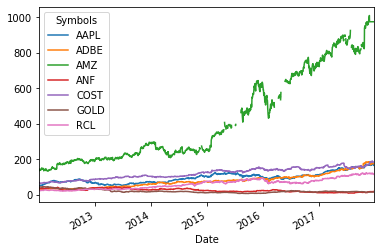

In [8]:
# Loading Train Data
# Setting Start and Enddate for Validation

start_train= datetime.datetime(2012, 1, 1)
end_train = datetime.datetime(2018, 1, 1)
start_val = end_train
end_val = datetime.datetime.now()


# Load Test Data

# Load several stocks
df_train = web.DataReader(['ADBE', 'AAPL', 'RCL', 'COST', 'ANF','AMZ', 'GOLD'],'yahoo',
                               start=start_train, end=end_train)['Adj Close']

df2_train = web.DataReader('GOLD','yahoo',
                               start=start_train, #start_train
                               end=end_train) #end_train


df_val = web.DataReader(['ADBE', 'AAPL', 'RCL', 'COST', 'ANF','AMZ', 'GOLD'],'yahoo',
                               start=start_val, #start_train
                               end=end_val)['Adj Close'] #end_val
df2_val = web.DataReader('GOLD','yahoo',
                               start=start_val, #start_val
                               end=end_val)  #end_val


# Convert df2_test to list
df2_train_list = list(df2_train['Adj Close'])
df2_val_list = list(df2_val['Adj Close'])

plt.figure();
df_train.plot();

## Training of Model
 - List of stocks (loaded above) is shuffled in every epoch

In [ ]:
#Training
coloredlogs.install(level='DEBUG')
switch_k_backend_device() #switches to CPU (acc. to author faster than GPU)


if df2_train is not None:
    agent = Agent(window_size*2, pretrained=False, model_name=model_name)
else:
    agent = Agent(window_size, pretrained=False, model_name=model_name)



reslist_t =[] # Train Reward for plotting
reslist_v = [] # Val Reward for plotting


for i in range(1, ep_count + 1): 
    #shuffle columns of training data
    cols = df_train.columns.values
    np.random.shuffle(cols)
    df_train_s = df_train[cols]
    print(df_train_s.head())

    #print(cols)

    for column in df_train_s:
        #create list
        df_train_list = list(df_train_s[column])
        df_val_list = list(df_val[column])

        #dft = df_test.rename(columns={column: 'actual'})
        initial_offset = df_train_list[1] - df_train_list[0]
                
        train_result = train_model(agent, i, df_train_list, df2_train_list, ep_count=ep_count,
                                batch_size=batch_size, window_size=window_size)
        val_result, _ = evaluate_model(agent, df_val_list, df2_val_list, window_size, debug)
        show_train_result(train_result, val_result, initial_offset)
      
        reslist_t.append(train_result[2]) # append reward of training
        reslist_v.append(val_result)
        
# Plotting Training History  
plt.figure(figsize = (15,5))
plt.plot(reslist_t, label = "Training Reward");
plt.plot(reslist_v, label = "Validation Reward");
plt.title("Reward")
plt.xlabel("Epochs")
plt.legend()
plt.show()



I1005 21:45:19.926573   992 train.py:156] switching to TensorFlow for CPU
2019-10-05 21:45:19 PC-Stefan root[11196] DEBUG switching to TensorFlow for CPU


Symbols          GOLD        AMZ       ADBE        ANF       COST        AAPL  \
Date                                                                            
2012-01-03  28.570000  42.415550  51.269413  37.513138  22.028625  135.250000   
2012-01-04  28.280001  43.049412  51.544937  36.262455  22.215746  137.399994   
2012-01-05  28.480000  42.870869  52.117188  35.211254  22.113682  137.600006   
2012-01-06  28.719999  42.442329  52.662014  34.459309  21.688419  144.449997   
2012-01-09  28.530001  42.594097  52.578468  35.011761  21.756460  139.350006   

Symbols           RCL  
Date                   
2012-01-03  67.481003  
2012-01-04  67.058258  
2012-01-05  66.412148  
2012-01-06  64.713181  
2012-01-09  63.022152  


Episode 1/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.02it/s]
I1005 21:45:40.551078   992 train.py:144] Episode 1/100 - Train Position: +$79.87  Val Position: USELESS  Train Loss: 0.0175  (~20.3753 secs)
2019-10-05 21:45:40 PC-Stefan root[11196] INFO Episode 1/100 - Train Position: +$79.87  Val Position: USELESS  Train Loss: 0.0175  (~20.3753 secs)
Episode 1/100: 100%|██████████| 1508/1508 [00:20<00:00, 73.93it/s]
I1005 21:46:01.116784   992 train.py:144] Episode 1/100 - Train Position: -$19.97  Val Position: USELESS  Train Loss: 0.0071  (~20.4007 secs)
2019-10-05 21:46:01 PC-Stefan root[11196] INFO Episode 1/100 - Train Position: -$19.97  Val Position: USELESS  Train Loss: 0.0071  (~20.4007 secs)
Episode 1/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.15it/s]
I1005 21:46:21.618827   992 train.py:144] Episode 1/100 - Train Position: +$191.56  Val Position: USELESS  Train Loss: nan  (~20.3375 secs)
2019-10-05 21:46:21 PC-Stefan root[11196] INFO Episode 1/100 - Train Position: +$

Symbols           ANF        COST       AAPL        AMZ       GOLD       ADBE  \
Date                                                                            
2012-01-03  42.415550  135.250000  67.481003  28.570000  51.269413  37.513138   
2012-01-04  43.049412  137.399994  67.058258  28.280001  51.544937  36.262455   
2012-01-05  42.870869  137.600006  66.412148  28.480000  52.117188  35.211254   
2012-01-06  42.442329  144.449997  64.713181  28.719999  52.662014  34.459309   
2012-01-09  42.594097  139.350006  63.022152  28.530001  52.578468  35.011761   

Symbols           RCL  
Date                   
2012-01-03  22.028625  
2012-01-04  22.215746  
2012-01-05  22.113682  
2012-01-06  21.688419  
2012-01-09  21.756460  


Episode 2/100: 100%|██████████| 1508/1508 [00:21<00:00, 69.88it/s]
I1005 21:48:06.347465   992 train.py:144] Episode 2/100 - Train Position: -$15.66  Val Position: USELESS  Train Loss: nan  (~21.5818 secs)
2019-10-05 21:48:06 PC-Stefan root[11196] INFO Episode 2/100 - Train Position: -$15.66  Val Position: USELESS  Train Loss: nan  (~21.5818 secs)
Episode 2/100: 100%|██████████| 1508/1508 [00:20<00:00, 72.38it/s]
I1005 21:48:27.341249   992 train.py:144] Episode 2/100 - Train Position: +$190.10  Val Position: USELESS  Train Loss: nan  (~20.8361 secs)
2019-10-05 21:48:27 PC-Stefan root[11196] INFO Episode 2/100 - Train Position: +$190.10  Val Position: USELESS  Train Loss: nan  (~20.8361 secs)
Episode 2/100: 100%|██████████| 1508/1508 [00:22<00:00, 67.95it/s]
I1005 21:48:49.730178   992 train.py:144] Episode 2/100 - Train Position: +$8.83  Val Position: USELESS  Train Loss: nan  (~22.1929 secs)
2019-10-05 21:48:49 PC-Stefan root[11196] INFO Episode 2/100 - Train Position: +$8.83  Val Po

Symbols           RCL        ADBE        AMZ       GOLD       COST        ANF  \
Date                                                                            
2012-01-03  42.415550  135.250000  28.570000  51.269413  67.481003  22.028625   
2012-01-04  43.049412  137.399994  28.280001  51.544937  67.058258  22.215746   
2012-01-05  42.870869  137.600006  28.480000  52.117188  66.412148  22.113682   
2012-01-06  42.442329  144.449997  28.719999  52.662014  64.713181  21.688419   
2012-01-09  42.594097  139.350006  28.530001  52.578468  63.022152  21.756460   

Symbols          AAPL  
Date                   
2012-01-03  37.513138  
2012-01-04  36.262455  
2012-01-05  35.211254  
2012-01-06  34.459309  
2012-01-09  35.011761  


Episode 3/100: 100%|██████████| 1508/1508 [00:22<00:00, 67.70it/s]
I1005 21:50:37.186030   992 train.py:144] Episode 3/100 - Train Position: -$31.28  Val Position: USELESS  Train Loss: nan  (~22.2755 secs)
2019-10-05 21:50:37 PC-Stefan root[11196] INFO Episode 3/100 - Train Position: -$31.28  Val Position: USELESS  Train Loss: nan  (~22.2755 secs)
Episode 3/100: 100%|██████████| 1508/1508 [00:20<00:00, 73.75it/s]
I1005 21:50:57.805811   992 train.py:144] Episode 3/100 - Train Position: +$nan  Val Position: USELESS  Train Loss: nan  (~20.4487 secs)
2019-10-05 21:50:57 PC-Stefan root[11196] INFO Episode 3/100 - Train Position: +$nan  Val Position: USELESS  Train Loss: nan  (~20.4487 secs)
Episode 3/100: 100%|██████████| 1508/1508 [00:21<00:00, 69.56it/s]
I1005 21:51:19.640750   992 train.py:144] Episode 3/100 - Train Position: +$30.59  Val Position: USELESS  Train Loss: nan  (~21.6806 secs)
2019-10-05 21:51:19 PC-Stefan root[11196] INFO Episode 3/100 - Train Position: +$30.59  Val Positi

Symbols          COST        ANF       ADBE       GOLD        AMZ         RCL  \
Date                                                                            
2012-01-03  37.513138  51.269413  22.028625  67.481003  42.415550  135.250000   
2012-01-04  36.262455  51.544937  22.215746  67.058258  43.049412  137.399994   
2012-01-05  35.211254  52.117188  22.113682  66.412148  42.870869  137.600006   
2012-01-06  34.459309  52.662014  21.688419  64.713181  42.442329  144.449997   
2012-01-09  35.011761  52.578468  21.756460  63.022152  42.594097  139.350006   

Symbols          AAPL  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 4/100: 100%|██████████| 1508/1508 [00:18<00:00, 81.28it/s]
I1005 21:52:54.582528   992 train.py:144] Episode 4/100 - Train Position: -$23.82  Val Position: USELESS  Train Loss: nan  (~18.5529 secs)
2019-10-05 21:52:54 PC-Stefan root[11196] INFO Episode 4/100 - Train Position: -$23.82  Val Position: USELESS  Train Loss: nan  (~18.5529 secs)
Episode 4/100: 100%|██████████| 1508/1508 [00:18<00:00, 81.21it/s]
I1005 21:53:13.300728   992 train.py:144] Episode 4/100 - Train Position: +$4.86  Val Position: USELESS  Train Loss: nan  (~18.5703 secs)
2019-10-05 21:53:13 PC-Stefan root[11196] INFO Episode 4/100 - Train Position: +$4.86  Val Position: USELESS  Train Loss: nan  (~18.5703 secs)
Episode 4/100: 100%|██████████| 1508/1508 [00:18<00:00, 81.17it/s]
I1005 21:53:32.027931   992 train.py:144] Episode 4/100 - Train Position: +$44.22  Val Position: USELESS  Train Loss: nan  (~18.5788 secs)
2019-10-05 21:53:32 PC-Stefan root[11196] INFO Episode 4/100 - Train Position: +$44.22  Val Posi

Symbols           RCL        COST       AAPL       ADBE        ANF       GOLD  \
Date                                                                            
2012-01-03  37.513138  135.250000  67.481003  22.028625  51.269413  42.415550   
2012-01-04  36.262455  137.399994  67.058258  22.215746  51.544937  43.049412   
2012-01-05  35.211254  137.600006  66.412148  22.113682  52.117188  42.870869   
2012-01-06  34.459309  144.449997  64.713181  21.688419  52.662014  42.442329   
2012-01-09  35.011761  139.350006  63.022152  21.756460  52.578468  42.594097   

Symbols           AMZ  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 5/100: 100%|██████████| 1508/1508 [00:18<00:00, 80.95it/s]
I1005 21:55:05.878992   992 train.py:144] Episode 5/100 - Train Position: +$4.19  Val Position: USELESS  Train Loss: nan  (~18.6303 secs)
2019-10-05 21:55:05 PC-Stefan root[11196] INFO Episode 5/100 - Train Position: +$4.19  Val Position: USELESS  Train Loss: nan  (~18.6303 secs)
Episode 5/100: 100%|██████████| 1508/1508 [00:18<00:00, 80.08it/s]
I1005 21:55:24.862252   992 train.py:144] Episode 5/100 - Train Position: +$33.50  Val Position: USELESS  Train Loss: nan  (~18.8337 secs)
2019-10-05 21:55:24 PC-Stefan root[11196] INFO Episode 5/100 - Train Position: +$33.50  Val Position: USELESS  Train Loss: nan  (~18.8337 secs)
Episode 5/100: 100%|██████████| 1508/1508 [00:18<00:00, 80.68it/s]
I1005 21:55:43.705482   992 train.py:144] Episode 5/100 - Train Position: +$115.33  Val Position: USELESS  Train Loss: nan  (~18.6939 secs)
2019-10-05 21:55:43 PC-Stefan root[11196] INFO Episode 5/100 - Train Position: +$115.33  Val Po

Symbols           AMZ       COST       AAPL        ANF        ADBE       GOLD  \
Date                                                                            
2012-01-03  67.481003  51.269413  28.570000  42.415550  135.250000  37.513138   
2012-01-04  67.058258  51.544937  28.280001  43.049412  137.399994  36.262455   
2012-01-05  66.412148  52.117188  28.480000  42.870869  137.600006  35.211254   
2012-01-06  64.713181  52.662014  28.719999  42.442329  144.449997  34.459309   
2012-01-09  63.022152  52.578468  28.530001  42.594097  139.350006  35.011761   

Symbols           RCL  
Date                   
2012-01-03  22.028625  
2012-01-04  22.215746  
2012-01-05  22.113682  
2012-01-06  21.688419  
2012-01-09  21.756460  


Episode 6/100: 100%|██████████| 1508/1508 [00:18<00:00, 80.69it/s]
I1005 21:57:17.829605   992 train.py:144] Episode 6/100 - Train Position: +$105.32  Val Position: USELESS  Train Loss: nan  (~18.6912 secs)
2019-10-05 21:57:17 PC-Stefan root[11196] INFO Episode 6/100 - Train Position: +$105.32  Val Position: USELESS  Train Loss: nan  (~18.6912 secs)
Episode 6/100: 100%|██████████| 1508/1508 [00:18<00:00, 80.59it/s]
I1005 21:57:36.693838   992 train.py:144] Episode 6/100 - Train Position: +$118.58  Val Position: USELESS  Train Loss: nan  (~18.7117 secs)
2019-10-05 21:57:36 PC-Stefan root[11196] INFO Episode 6/100 - Train Position: +$118.58  Val Position: USELESS  Train Loss: nan  (~18.7117 secs)
Episode 6/100: 100%|██████████| 1508/1508 [00:18<00:00, 80.61it/s]
I1005 21:57:55.551070   992 train.py:144] Episode 6/100 - Train Position: +$14.96  Val Position: USELESS  Train Loss: nan  (~18.7075 secs)
2019-10-05 21:57:55 PC-Stefan root[11196] INFO Episode 6/100 - Train Position: +$14.96  Va

Symbols          ADBE        RCL       GOLD        COST        ANF        AMZ  \
Date                                                                            
2012-01-03  22.028625  51.269413  67.481003  135.250000  42.415550  37.513138   
2012-01-04  22.215746  51.544937  67.058258  137.399994  43.049412  36.262455   
2012-01-05  22.113682  52.117188  66.412148  137.600006  42.870869  35.211254   
2012-01-06  21.688419  52.662014  64.713181  144.449997  42.442329  34.459309   
2012-01-09  21.756460  52.578468  63.022152  139.350006  42.594097  35.011761   

Symbols          AAPL  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 7/100: 100%|██████████| 1508/1508 [00:18<00:00, 81.24it/s]
I1005 21:59:29.394130   992 train.py:144] Episode 7/100 - Train Position: +$135.11  Val Position: USELESS  Train Loss: nan  (~18.5641 secs)
2019-10-05 21:59:29 PC-Stefan root[11196] INFO Episode 7/100 - Train Position: +$135.11  Val Position: USELESS  Train Loss: nan  (~18.5641 secs)
Episode 7/100: 100%|██████████| 1508/1508 [00:19<00:00, 78.75it/s]
I1005 21:59:48.693461   992 train.py:144] Episode 7/100 - Train Position: +$58.74  Val Position: USELESS  Train Loss: nan  (~19.1504 secs)
2019-10-05 21:59:48 PC-Stefan root[11196] INFO Episode 7/100 - Train Position: +$58.74  Val Position: USELESS  Train Loss: nan  (~19.1504 secs)
Episode 7/100: 100%|██████████| 1508/1508 [00:18<00:00, 81.27it/s]
I1005 22:00:07.399660   992 train.py:144] Episode 7/100 - Train Position: +$38.63  Val Position: USELESS  Train Loss: nan  (~18.5582 secs)
2019-10-05 22:00:07 PC-Stefan root[11196] INFO Episode 7/100 - Train Position: +$38.63  Val 

Symbols          AAPL       ADBE       COST        ANF         RCL       GOLD  \
Date                                                                            
2012-01-03  37.513138  28.570000  22.028625  51.269413  135.250000  42.415550   
2012-01-04  36.262455  28.280001  22.215746  51.544937  137.399994  43.049412   
2012-01-05  35.211254  28.480000  22.113682  52.117188  137.600006  42.870869   
2012-01-06  34.459309  28.719999  21.688419  52.662014  144.449997  42.442329   
2012-01-09  35.011761  28.530001  21.756460  52.578468  139.350006  42.594097   

Symbols           AMZ  
Date                   
2012-01-03  67.481003  
2012-01-04  67.058258  
2012-01-05  66.412148  
2012-01-06  64.713181  
2012-01-09  63.022152  


Episode 8/100: 100%|██████████| 1508/1508 [00:18<00:00, 80.70it/s]
I1005 22:01:41.284729   992 train.py:144] Episode 8/100 - Train Position: -$53.07  Val Position: USELESS  Train Loss: nan  (~18.6872 secs)
2019-10-05 22:01:41 PC-Stefan root[11196] INFO Episode 8/100 - Train Position: -$53.07  Val Position: USELESS  Train Loss: nan  (~18.6872 secs)
Episode 8/100: 100%|██████████| 1508/1508 [00:18<00:00, 80.76it/s]
I1005 22:02:00.109953   992 train.py:144] Episode 8/100 - Train Position: +$21.49  Val Position: USELESS  Train Loss: nan  (~18.6741 secs)
2019-10-05 22:02:00 PC-Stefan root[11196] INFO Episode 8/100 - Train Position: +$21.49  Val Position: USELESS  Train Loss: nan  (~18.6741 secs)
Episode 8/100: 100%|██████████| 1508/1508 [00:18<00:00, 80.96it/s]
I1005 22:02:18.887167   992 train.py:144] Episode 8/100 - Train Position: +$40.65  Val Position: USELESS  Train Loss: nan  (~18.6278 secs)
2019-10-05 22:02:18 PC-Stefan root[11196] INFO Episode 8/100 - Train Position: +$40.65  Val Po

Symbols          ADBE        AMZ       GOLD        ANF        AAPL       COST  \
Date                                                                            
2012-01-03  42.415550  67.481003  51.269413  22.028625  135.250000  28.570000   
2012-01-04  43.049412  67.058258  51.544937  22.215746  137.399994  28.280001   
2012-01-05  42.870869  66.412148  52.117188  22.113682  137.600006  28.480000   
2012-01-06  42.442329  64.713181  52.662014  21.688419  144.449997  28.719999   
2012-01-09  42.594097  63.022152  52.578468  21.756460  139.350006  28.530001   

Symbols           RCL  
Date                   
2012-01-03  37.513138  
2012-01-04  36.262455  
2012-01-05  35.211254  
2012-01-06  34.459309  
2012-01-09  35.011761  


Episode 9/100: 100%|██████████| 1508/1508 [00:22<00:00, 67.71it/s]
I1005 22:04:07.428901   992 train.py:144] Episode 9/100 - Train Position: -$10.35  Val Position: USELESS  Train Loss: nan  (~22.2721 secs)
2019-10-05 22:04:07 PC-Stefan root[11196] INFO Episode 9/100 - Train Position: -$10.35  Val Position: USELESS  Train Loss: nan  (~22.2721 secs)
Episode 9/100: 100%|██████████| 1508/1508 [00:22<00:00, 65.59it/s]
I1005 22:04:30.626338   992 train.py:144] Episode 9/100 - Train Position: +$27.26  Val Position: USELESS  Train Loss: nan  (~22.9940 secs)
2019-10-05 22:04:30 PC-Stefan root[11196] INFO Episode 9/100 - Train Position: +$27.26  Val Position: USELESS  Train Loss: nan  (~22.9940 secs)
Episode 9/100: 100%|██████████| 1508/1508 [00:22<00:00, 66.18it/s]
I1005 22:04:53.579211   992 train.py:144] Episode 9/100 - Train Position: +$17.09  Val Position: USELESS  Train Loss: nan  (~22.7844 secs)
2019-10-05 22:04:53 PC-Stefan root[11196] INFO Episode 9/100 - Train Position: +$17.09  Val Po

Symbols           RCL        AMZ       COST        AAPL       ADBE       GOLD  \
Date                                                                            
2012-01-03  67.481003  37.513138  51.269413  135.250000  22.028625  42.415550   
2012-01-04  67.058258  36.262455  51.544937  137.399994  22.215746  43.049412   
2012-01-05  66.412148  35.211254  52.117188  137.600006  22.113682  42.870869   
2012-01-06  64.713181  34.459309  52.662014  144.449997  21.688419  42.442329   
2012-01-09  63.022152  35.011761  52.578468  139.350006  21.756460  42.594097   

Symbols           ANF  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 10/100: 100%|██████████| 1508/1508 [00:23<00:00, 64.69it/s]
I1005 22:06:48.020544   992 train.py:144] Episode 10/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~23.3137 secs)
2019-10-05 22:06:48 PC-Stefan root[11196] INFO Episode 10/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~23.3137 secs)
Episode 10/100: 100%|██████████| 1508/1508 [00:22<00:00, 68.02it/s]
I1005 22:07:10.410264   992 train.py:144] Episode 10/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~22.1730 secs)
2019-10-05 22:07:10 PC-Stefan root[11196] INFO Episode 10/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~22.1730 secs)
Episode 10/100: 100%|██████████| 1508/1508 [00:22<00:00, 67.37it/s]
I1005 22:07:33.042426   992 train.py:144] Episode 10/100 - Train Position: +$8.57  Val Position: USELESS  Train Loss: nan  (~22.3854 secs)
2019-10-05 22:07:33 PC-Stefan root[11196] INFO Episode 10/100 - Train Position: +$8.57  Val

Symbols          AAPL        AMZ        RCL       GOLD         ANF       COST  \
Date                                                                            
2012-01-03  51.269413  67.481003  37.513138  22.028625  135.250000  28.570000   
2012-01-04  51.544937  67.058258  36.262455  22.215746  137.399994  28.280001   
2012-01-05  52.117188  66.412148  35.211254  22.113682  137.600006  28.480000   
2012-01-06  52.662014  64.713181  34.459309  21.688419  144.449997  28.719999   
2012-01-09  52.578468  63.022152  35.011761  21.756460  139.350006  28.530001   

Symbols          ADBE  
Date                   
2012-01-03  42.415550  
2012-01-04  43.049412  
2012-01-05  42.870869  
2012-01-06  42.442329  
2012-01-09  42.594097  


Episode 11/100: 100%|██████████| 1508/1508 [00:21<00:00, 68.68it/s]
I1005 22:09:27.349365   992 train.py:144] Episode 11/100 - Train Position: +$91.61  Val Position: USELESS  Train Loss: nan  (~21.9586 secs)
2019-10-05 22:09:27 PC-Stefan root[11196] INFO Episode 11/100 - Train Position: +$91.61  Val Position: USELESS  Train Loss: nan  (~21.9586 secs)
Episode 11/100: 100%|██████████| 1508/1508 [00:20<00:00, 73.31it/s]
I1005 22:09:48.081918   992 train.py:144] Episode 11/100 - Train Position: +$29.05  Val Position: USELESS  Train Loss: nan  (~20.5705 secs)
2019-10-05 22:09:48 PC-Stefan root[11196] INFO Episode 11/100 - Train Position: +$29.05  Val Position: USELESS  Train Loss: nan  (~20.5705 secs)
Episode 11/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.03it/s]
I1005 22:10:08.610928   992 train.py:144] Episode 11/100 - Train Position: -$20.61  Val Position: USELESS  Train Loss: nan  (~20.3704 secs)
2019-10-05 22:10:08 PC-Stefan root[11196] INFO Episode 11/100 - Train Position: -$20.6

Symbols            RCL       COST       GOLD       ADBE        ANF        AMZ  \
Date                                                                            
2012-01-03  135.250000  37.513138  22.028625  67.481003  28.570000  51.269413   
2012-01-04  137.399994  36.262455  22.215746  67.058258  28.280001  51.544937   
2012-01-05  137.600006  35.211254  22.113682  66.412148  28.480000  52.117188   
2012-01-06  144.449997  34.459309  21.688419  64.713181  28.719999  52.662014   
2012-01-09  139.350006  35.011761  21.756460  63.022152  28.530001  52.578468   

Symbols          AAPL  
Date                   
2012-01-03  42.415550  
2012-01-04  43.049412  
2012-01-05  42.870869  
2012-01-06  42.442329  
2012-01-09  42.594097  


Episode 12/100: 100%|██████████| 1508/1508 [00:20<00:00, 72.99it/s]
I1005 22:11:53.446262   992 train.py:144] Episode 12/100 - Train Position: +$136.85  Val Position: USELESS  Train Loss: nan  (~20.6598 secs)
2019-10-05 22:11:53 PC-Stefan root[11196] INFO Episode 12/100 - Train Position: +$136.85  Val Position: USELESS  Train Loss: nan  (~20.6598 secs)
Episode 12/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.14it/s]
I1005 22:12:13.938253   992 train.py:144] Episode 12/100 - Train Position: -$25.24  Val Position: USELESS  Train Loss: nan  (~20.3401 secs)
2019-10-05 22:12:13 PC-Stefan root[11196] INFO Episode 12/100 - Train Position: -$25.24  Val Position: USELESS  Train Loss: nan  (~20.3401 secs)
Episode 12/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.01it/s]
I1005 22:12:34.200299   992 train.py:144] Episode 12/100 - Train Position: +$201.11  Val Position: USELESS  Train Loss: nan  (~20.1057 secs)
2019-10-05 22:12:34 PC-Stefan root[11196] INFO Episode 12/100 - Train Position: +$2

Symbols           ANF       ADBE         AMZ        RCL       GOLD       AAPL  \
Date                                                                            
2012-01-03  67.481003  28.570000  135.250000  42.415550  37.513138  22.028625   
2012-01-04  67.058258  28.280001  137.399994  43.049412  36.262455  22.215746   
2012-01-05  66.412148  28.480000  137.600006  42.870869  35.211254  22.113682   
2012-01-06  64.713181  28.719999  144.449997  42.442329  34.459309  21.688419   
2012-01-09  63.022152  28.530001  139.350006  42.594097  35.011761  21.756460   

Symbols          COST  
Date                   
2012-01-03  51.269413  
2012-01-04  51.544937  
2012-01-05  52.117188  
2012-01-06  52.662014  
2012-01-09  52.578468  


Episode 13/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.29it/s]
I1005 22:14:15.702672   992 train.py:144] Episode 13/100 - Train Position: +$163.14  Val Position: USELESS  Train Loss: nan  (~19.7678 secs)
2019-10-05 22:14:15 PC-Stefan root[11196] INFO Episode 13/100 - Train Position: +$163.14  Val Position: USELESS  Train Loss: nan  (~19.7678 secs)
Episode 13/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.00it/s]
I1005 22:14:35.449357   992 train.py:144] Episode 13/100 - Train Position: +$105.55  Val Position: USELESS  Train Loss: nan  (~19.5877 secs)
2019-10-05 22:14:35 PC-Stefan root[11196] INFO Episode 13/100 - Train Position: +$105.55  Val Position: USELESS  Train Loss: nan  (~19.5877 secs)
Episode 13/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.83it/s]
I1005 22:14:54.991740   992 train.py:144] Episode 13/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~19.3772 secs)
2019-10-05 22:14:54 PC-Stefan root[11196] INFO Episode 13/100 - Train Position: +$0

Symbols          AAPL       COST         AMZ        RCL       GOLD        ANF  \
Date                                                                            
2012-01-03  51.269413  37.513138  135.250000  67.481003  22.028625  28.570000   
2012-01-04  51.544937  36.262455  137.399994  67.058258  22.215746  28.280001   
2012-01-05  52.117188  35.211254  137.600006  66.412148  22.113682  28.480000   
2012-01-06  52.662014  34.459309  144.449997  64.713181  21.688419  28.719999   
2012-01-09  52.578468  35.011761  139.350006  63.022152  21.756460  28.530001   

Symbols          ADBE  
Date                   
2012-01-03  42.415550  
2012-01-04  43.049412  
2012-01-05  42.870869  
2012-01-06  42.442329  
2012-01-09  42.594097  


Episode 14/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.33it/s]
I1005 22:16:34.188117   992 train.py:144] Episode 14/100 - Train Position: +$5.45  Val Position: USELESS  Train Loss: nan  (~19.7557 secs)
2019-10-05 22:16:34 PC-Stefan root[11196] INFO Episode 14/100 - Train Position: +$5.45  Val Position: USELESS  Train Loss: nan  (~19.7557 secs)
Episode 14/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.63it/s]
I1005 22:16:54.029096   992 train.py:144] Episode 14/100 - Train Position: -$31.00  Val Position: USELESS  Train Loss: nan  (~19.6818 secs)
2019-10-05 22:16:54 PC-Stefan root[11196] INFO Episode 14/100 - Train Position: -$31.00  Val Position: USELESS  Train Loss: nan  (~19.6818 secs)
Episode 14/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.60it/s]
I1005 22:17:13.868708   992 train.py:144] Episode 14/100 - Train Position: +$607.45  Val Position: USELESS  Train Loss: nan  (~19.6876 secs)
2019-10-05 22:17:13 PC-Stefan root[11196] INFO Episode 14/100 - Train Position: +$607.4

Symbols           AMZ       AAPL       ADBE        ANF        RCL        COST  \
Date                                                                            
2012-01-03  42.415550  22.028625  67.481003  37.513138  28.570000  135.250000   
2012-01-04  43.049412  22.215746  67.058258  36.262455  28.280001  137.399994   
2012-01-05  42.870869  22.113682  66.412148  35.211254  28.480000  137.600006   
2012-01-06  42.442329  21.688419  64.713181  34.459309  28.719999  144.449997   
2012-01-09  42.594097  21.756460  63.022152  35.011761  28.530001  139.350006   

Symbols          GOLD  
Date                   
2012-01-03  51.269413  
2012-01-04  51.544937  
2012-01-05  52.117188  
2012-01-06  52.662014  
2012-01-09  52.578468  


Episode 15/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.97it/s]
I1005 22:18:53.726284   992 train.py:144] Episode 15/100 - Train Position: +$0.37  Val Position: USELESS  Train Loss: nan  (~19.8522 secs)
2019-10-05 22:18:53 PC-Stefan root[11196] INFO Episode 15/100 - Train Position: +$0.37  Val Position: USELESS  Train Loss: nan  (~19.8522 secs)
Episode 15/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.83it/s]
I1005 22:19:13.787783   992 train.py:144] Episode 15/100 - Train Position: +$111.82  Val Position: USELESS  Train Loss: nan  (~19.8882 secs)
2019-10-05 22:19:13 PC-Stefan root[11196] INFO Episode 15/100 - Train Position: +$111.82  Val Position: USELESS  Train Loss: nan  (~19.8882 secs)
Episode 15/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.06it/s]
I1005 22:19:33.523024   992 train.py:144] Episode 15/100 - Train Position: +$131.53  Val Position: USELESS  Train Loss: nan  (~19.5700 secs)
2019-10-05 22:19:33 PC-Stefan root[11196] INFO Episode 15/100 - Train Position: +$131

Symbols           ADBE        AMZ       AAPL       COST        RCL       GOLD  \
Date                                                                            
2012-01-03  135.250000  51.269413  28.570000  22.028625  37.513138  42.415550   
2012-01-04  137.399994  51.544937  28.280001  22.215746  36.262455  43.049412   
2012-01-05  137.600006  52.117188  28.480000  22.113682  35.211254  42.870869   
2012-01-06  144.449997  52.662014  28.719999  21.688419  34.459309  42.442329   
2012-01-09  139.350006  52.578468  28.530001  21.756460  35.011761  42.594097   

Symbols           ANF  
Date                   
2012-01-03  67.481003  
2012-01-04  67.058258  
2012-01-05  66.412148  
2012-01-06  64.713181  
2012-01-09  63.022152  


Episode 16/100: 100%|██████████| 1508/1508 [00:20<00:00, 73.91it/s]
I1005 22:21:13.713035   992 train.py:144] Episode 16/100 - Train Position: +$342.95  Val Position: USELESS  Train Loss: nan  (~20.4030 secs)
2019-10-05 22:21:13 PC-Stefan root[11196] INFO Episode 16/100 - Train Position: +$342.95  Val Position: USELESS  Train Loss: nan  (~20.4030 secs)
Episode 16/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.34it/s]
I1005 22:21:33.421265   992 train.py:144] Episode 16/100 - Train Position: +$43.23  Val Position: USELESS  Train Loss: nan  (~19.4990 secs)
2019-10-05 22:21:33 PC-Stefan root[11196] INFO Episode 16/100 - Train Position: +$43.23  Val Position: USELESS  Train Loss: nan  (~19.4990 secs)
Episode 16/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.27it/s]
I1005 22:21:53.354201   992 train.py:144] Episode 16/100 - Train Position: +$48.23  Val Position: USELESS  Train Loss: nan  (~19.7744 secs)
2019-10-05 22:21:53 PC-Stefan root[11196] INFO Episode 16/100 - Train Position: +$48

Symbols          AAPL       ADBE        AMZ        ANF       COST        GOLD  \
Date                                                                            
2012-01-03  51.269413  37.513138  42.415550  28.570000  22.028625  135.250000   
2012-01-04  51.544937  36.262455  43.049412  28.280001  22.215746  137.399994   
2012-01-05  52.117188  35.211254  42.870869  28.480000  22.113682  137.600006   
2012-01-06  52.662014  34.459309  42.442329  28.719999  21.688419  144.449997   
2012-01-09  52.578468  35.011761  42.594097  28.530001  21.756460  139.350006   

Symbols           RCL  
Date                   
2012-01-03  67.481003  
2012-01-04  67.058258  
2012-01-05  66.412148  
2012-01-06  64.713181  
2012-01-09  63.022152  


Episode 17/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.83it/s]
I1005 22:23:32.473354   992 train.py:144] Episode 17/100 - Train Position: +$89.59  Val Position: USELESS  Train Loss: nan  (~19.8882 secs)
2019-10-05 22:23:32 PC-Stefan root[11196] INFO Episode 17/100 - Train Position: +$89.59  Val Position: USELESS  Train Loss: nan  (~19.8882 secs)
Episode 17/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.87it/s]
I1005 22:23:52.506438   992 train.py:144] Episode 17/100 - Train Position: -$6.54  Val Position: USELESS  Train Loss: nan  (~19.8768 secs)
2019-10-05 22:23:52 PC-Stefan root[11196] INFO Episode 17/100 - Train Position: -$6.54  Val Position: USELESS  Train Loss: nan  (~19.8768 secs)
Episode 17/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.95it/s]
I1005 22:24:12.537618   992 train.py:144] Episode 17/100 - Train Position: +$5.41  Val Position: USELESS  Train Loss: nan  (~19.8571 secs)
2019-10-05 22:24:12 PC-Stefan root[11196] INFO Episode 17/100 - Train Position: +$5.41  V

Symbols          AAPL        GOLD       COST        ANF        AMZ       ADBE  \
Date                                                                            
2012-01-03  37.513138  135.250000  42.415550  51.269413  28.570000  67.481003   
2012-01-04  36.262455  137.399994  43.049412  51.544937  28.280001  67.058258   
2012-01-05  35.211254  137.600006  42.870869  52.117188  28.480000  66.412148   
2012-01-06  34.459309  144.449997  42.442329  52.662014  28.719999  64.713181   
2012-01-09  35.011761  139.350006  42.594097  52.578468  28.530001  63.022152   

Symbols           RCL  
Date                   
2012-01-03  22.028625  
2012-01-04  22.215746  
2012-01-05  22.113682  
2012-01-06  21.688419  
2012-01-09  21.756460  


Episode 18/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.82it/s]
I1005 22:25:52.894020   992 train.py:144] Episode 18/100 - Train Position: -$0.38  Val Position: USELESS  Train Loss: nan  (~19.6318 secs)
2019-10-05 22:25:52 PC-Stefan root[11196] INFO Episode 18/100 - Train Position: -$0.38  Val Position: USELESS  Train Loss: nan  (~19.6318 secs)
Episode 18/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.86it/s]
I1005 22:26:12.928515   992 train.py:144] Episode 18/100 - Train Position: +$567.98  Val Position: USELESS  Train Loss: nan  (~19.8793 secs)
2019-10-05 22:26:12 PC-Stefan root[11196] INFO Episode 18/100 - Train Position: +$567.98  Val Position: USELESS  Train Loss: nan  (~19.8793 secs)
Episode 18/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.19it/s]
I1005 22:26:32.618300   992 train.py:144] Episode 18/100 - Train Position: +$0.04  Val Position: USELESS  Train Loss: nan  (~19.5380 secs)
2019-10-05 22:26:32 PC-Stefan root[11196] INFO Episode 18/100 - Train Position: +$0.04 

Symbols          AAPL         ANF       GOLD       ADBE       COST        AMZ  \
Date                                                                            
2012-01-03  51.269413  135.250000  37.513138  42.415550  22.028625  28.570000   
2012-01-04  51.544937  137.399994  36.262455  43.049412  22.215746  28.280001   
2012-01-05  52.117188  137.600006  35.211254  42.870869  22.113682  28.480000   
2012-01-06  52.662014  144.449997  34.459309  42.442329  21.688419  28.719999   
2012-01-09  52.578468  139.350006  35.011761  42.594097  21.756460  28.530001   

Symbols           RCL  
Date                   
2012-01-03  67.481003  
2012-01-04  67.058258  
2012-01-05  66.412148  
2012-01-06  64.713181  
2012-01-09  63.022152  


Episode 19/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.05it/s]
I1005 22:28:12.767122   992 train.py:144] Episode 19/100 - Train Position: -$4.45  Val Position: USELESS  Train Loss: nan  (~20.0942 secs)
2019-10-05 22:28:12 PC-Stefan root[11196] INFO Episode 19/100 - Train Position: -$4.45  Val Position: USELESS  Train Loss: nan  (~20.0942 secs)
Episode 19/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.64it/s]
I1005 22:28:32.593580   992 train.py:144] Episode 19/100 - Train Position: +$1972.05  Val Position: USELESS  Train Loss: nan  (~19.6775 secs)
2019-10-05 22:28:32 PC-Stefan root[11196] INFO Episode 19/100 - Train Position: +$1972.05  Val Position: USELESS  Train Loss: nan  (~19.6775 secs)
Episode 19/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.30it/s]
I1005 22:28:52.510479   992 train.py:144] Episode 19/100 - Train Position: -$14.62  Val Position: USELESS  Train Loss: nan  (~19.7656 secs)
2019-10-05 22:28:52 PC-Stefan root[11196] INFO Episode 19/100 - Train Position: -$14

Symbols           COST       ADBE       GOLD        ANF        RCL       AAPL  \
Date                                                                            
2012-01-03  135.250000  28.570000  67.481003  37.513138  42.415550  22.028625   
2012-01-04  137.399994  28.280001  67.058258  36.262455  43.049412  22.215746   
2012-01-05  137.600006  28.480000  66.412148  35.211254  42.870869  22.113682   
2012-01-06  144.449997  28.719999  64.713181  34.459309  42.442329  21.688419   
2012-01-09  139.350006  28.530001  63.022152  35.011761  42.594097  21.756460   

Symbols           AMZ  
Date                   
2012-01-03  51.269413  
2012-01-04  51.544937  
2012-01-05  52.117188  
2012-01-06  52.662014  
2012-01-09  52.578468  


Episode 20/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.38it/s]
I1005 22:30:32.828490   992 train.py:144] Episode 20/100 - Train Position: +$1051.45  Val Position: USELESS  Train Loss: nan  (~19.7447 secs)
2019-10-05 22:30:32 PC-Stefan root[11196] INFO Episode 20/100 - Train Position: +$1051.45  Val Position: USELESS  Train Loss: nan  (~19.7447 secs)
Episode 20/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.42it/s]
I1005 22:30:52.999699   992 train.py:144] Episode 20/100 - Train Position: +$192.93  Val Position: USELESS  Train Loss: nan  (~19.9964 secs)
2019-10-05 22:30:52 PC-Stefan root[11196] INFO Episode 20/100 - Train Position: +$192.93  Val Position: USELESS  Train Loss: nan  (~19.9964 secs)
Episode 20/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.81it/s]
I1005 22:31:12.560512   992 train.py:144] Episode 20/100 - Train Position: +$124.79  Val Position: USELESS  Train Loss: nan  (~19.3821 secs)
2019-10-05 22:31:12 PC-Stefan root[11196] INFO Episode 20/100 - Train Position:

Symbols          COST        RCL       ADBE       AAPL        AMZ         ANF  \
Date                                                                            
2012-01-03  22.028625  51.269413  37.513138  28.570000  42.415550  135.250000   
2012-01-04  22.215746  51.544937  36.262455  28.280001  43.049412  137.399994   
2012-01-05  22.113682  52.117188  35.211254  28.480000  42.870869  137.600006   
2012-01-06  21.688419  52.662014  34.459309  28.719999  42.442329  144.449997   
2012-01-09  21.756460  52.578468  35.011761  28.530001  42.594097  139.350006   

Symbols          GOLD  
Date                   
2012-01-03  67.481003  
2012-01-04  67.058258  
2012-01-05  66.412148  
2012-01-06  64.713181  
2012-01-09  63.022152  


Episode 21/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.45it/s]
I1005 22:32:51.455310   992 train.py:144] Episode 21/100 - Train Position: +$51.66  Val Position: USELESS  Train Loss: nan  (~19.7238 secs)
2019-10-05 22:32:51 PC-Stefan root[11196] INFO Episode 21/100 - Train Position: +$51.66  Val Position: USELESS  Train Loss: nan  (~19.7238 secs)
Episode 21/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.20it/s]
I1005 22:33:11.402294   992 train.py:144] Episode 21/100 - Train Position: -$28.36  Val Position: USELESS  Train Loss: nan  (~19.7926 secs)
2019-10-05 22:33:11 PC-Stefan root[11196] INFO Episode 21/100 - Train Position: -$28.36  Val Position: USELESS  Train Loss: nan  (~19.7926 secs)
Episode 21/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.75it/s]
I1005 22:33:31.204034   992 train.py:144] Episode 21/100 - Train Position: +$8.13  Val Position: USELESS  Train Loss: nan  (~19.6493 secs)
2019-10-05 22:33:31 PC-Stefan root[11196] INFO Episode 21/100 - Train Position: +$8.13 

Symbols          ADBE        RCL         AMZ       COST       GOLD        ANF  \
Date                                                                            
2012-01-03  22.028625  51.269413  135.250000  42.415550  37.513138  67.481003   
2012-01-04  22.215746  51.544937  137.399994  43.049412  36.262455  67.058258   
2012-01-05  22.113682  52.117188  137.600006  42.870869  35.211254  66.412148   
2012-01-06  21.688419  52.662014  144.449997  42.442329  34.459309  64.713181   
2012-01-09  21.756460  52.578468  139.350006  42.594097  35.011761  63.022152   

Symbols          AAPL  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 22/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.45it/s]
I1005 22:35:11.760201   992 train.py:144] Episode 22/100 - Train Position: +$4.93  Val Position: USELESS  Train Loss: nan  (~20.2562 secs)
2019-10-05 22:35:11 PC-Stefan root[11196] INFO Episode 22/100 - Train Position: +$4.93  Val Position: USELESS  Train Loss: nan  (~20.2562 secs)
Episode 22/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.24it/s]
I1005 22:35:32.234393   992 train.py:144] Episode 22/100 - Train Position: +$84.88  Val Position: USELESS  Train Loss: nan  (~20.3147 secs)
2019-10-05 22:35:32 PC-Stefan root[11196] INFO Episode 22/100 - Train Position: +$84.88  Val Position: USELESS  Train Loss: nan  (~20.3147 secs)
Episode 22/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.08it/s]
I1005 22:35:52.212818   992 train.py:144] Episode 22/100 - Train Position: +$nan  Val Position: USELESS  Train Loss: nan  (~19.8225 secs)
2019-10-05 22:35:52 PC-Stefan root[11196] INFO Episode 22/100 - Train Position: +$nan  Val

Symbols           AMZ       GOLD        ANF       AAPL       COST         RCL  \
Date                                                                            
2012-01-03  42.415550  51.269413  22.028625  28.570000  67.481003  135.250000   
2012-01-04  43.049412  51.544937  22.215746  28.280001  67.058258  137.399994   
2012-01-05  42.870869  52.117188  22.113682  28.480000  66.412148  137.600006   
2012-01-06  42.442329  52.662014  21.688419  28.719999  64.713181  144.449997   
2012-01-09  42.594097  52.578468  21.756460  28.530001  63.022152  139.350006   

Symbols          ADBE  
Date                   
2012-01-03  37.513138  
2012-01-04  36.262455  
2012-01-05  35.211254  
2012-01-06  34.459309  
2012-01-09  35.011761  


Episode 23/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.17it/s]
I1005 22:37:32.729192   992 train.py:144] Episode 23/100 - Train Position: -$0.91  Val Position: USELESS  Train Loss: nan  (~19.7999 secs)
2019-10-05 22:37:32 PC-Stefan root[11196] INFO Episode 23/100 - Train Position: -$0.91  Val Position: USELESS  Train Loss: nan  (~19.7999 secs)
Episode 23/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.62it/s]
I1005 22:37:52.833802   992 train.py:144] Episode 23/100 - Train Position: +$124.47  Val Position: USELESS  Train Loss: nan  (~19.9453 secs)
2019-10-05 22:37:52 PC-Stefan root[11196] INFO Episode 23/100 - Train Position: +$124.47  Val Position: USELESS  Train Loss: nan  (~19.9453 secs)
Episode 23/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.55it/s]
I1005 22:38:13.220865   992 train.py:144] Episode 23/100 - Train Position: +$68.77  Val Position: USELESS  Train Loss: nan  (~20.2304 secs)
2019-10-05 22:38:13 PC-Stefan root[11196] INFO Episode 23/100 - Train Position: +$68.7

Symbols           AAPL       ADBE        AMZ       COST        RCL       GOLD  \
Date                                                                            
2012-01-03  135.250000  42.415550  51.269413  22.028625  37.513138  28.570000   
2012-01-04  137.399994  43.049412  51.544937  22.215746  36.262455  28.280001   
2012-01-05  137.600006  42.870869  52.117188  22.113682  35.211254  28.480000   
2012-01-06  144.449997  42.442329  52.662014  21.688419  34.459309  28.719999   
2012-01-09  139.350006  42.594097  52.578468  21.756460  35.011761  28.530001   

Symbols           ANF  
Date                   
2012-01-03  67.481003  
2012-01-04  67.058258  
2012-01-05  66.412148  
2012-01-06  64.713181  
2012-01-09  63.022152  


Episode 24/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.07it/s]
I1005 22:39:54.823620   992 train.py:144] Episode 24/100 - Train Position: +$665.80  Val Position: USELESS  Train Loss: nan  (~20.0889 secs)
2019-10-05 22:39:54 PC-Stefan root[11196] INFO Episode 24/100 - Train Position: +$665.80  Val Position: USELESS  Train Loss: nan  (~20.0889 secs)
Episode 24/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.13it/s]
I1005 22:40:14.797958   992 train.py:144] Episode 24/100 - Train Position: -$1.28  Val Position: USELESS  Train Loss: nan  (~19.8117 secs)
2019-10-05 22:40:14 PC-Stefan root[11196] INFO Episode 24/100 - Train Position: -$1.28  Val Position: USELESS  Train Loss: nan  (~19.8117 secs)
Episode 24/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.46it/s]
I1005 22:40:34.948759   992 train.py:144] Episode 24/100 - Train Position: +$5.90  Val Position: USELESS  Train Loss: nan  (~19.9891 secs)
2019-10-05 22:40:34 PC-Stefan root[11196] INFO Episode 24/100 - Train Position: +$5.90 

Symbols           ADBE       GOLD       COST        ANF        RCL       AAPL  \
Date                                                                            
2012-01-03  135.250000  67.481003  28.570000  37.513138  42.415550  22.028625   
2012-01-04  137.399994  67.058258  28.280001  36.262455  43.049412  22.215746   
2012-01-05  137.600006  66.412148  28.480000  35.211254  42.870869  22.113682   
2012-01-06  144.449997  64.713181  28.719999  34.459309  42.442329  21.688419   
2012-01-09  139.350006  63.022152  28.530001  35.011761  42.594097  21.756460   

Symbols           AMZ  
Date                   
2012-01-03  51.269413  
2012-01-04  51.544937  
2012-01-05  52.117188  
2012-01-06  52.662014  
2012-01-09  52.578468  


Episode 25/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.27it/s]
I1005 22:42:15.104020   992 train.py:144] Episode 25/100 - Train Position: +$795.25  Val Position: USELESS  Train Loss: nan  (~19.7716 secs)
2019-10-05 22:42:15 PC-Stefan root[11196] INFO Episode 25/100 - Train Position: +$795.25  Val Position: USELESS  Train Loss: nan  (~19.7716 secs)
Episode 25/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.07it/s]
I1005 22:42:35.090044   992 train.py:144] Episode 25/100 - Train Position: +$104.18  Val Position: USELESS  Train Loss: nan  (~19.8248 secs)
2019-10-05 22:42:35 PC-Stefan root[11196] INFO Episode 25/100 - Train Position: +$104.18  Val Position: USELESS  Train Loss: nan  (~19.8248 secs)
Episode 25/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.86it/s]
I1005 22:42:54.865161   992 train.py:144] Episode 25/100 - Train Position: +$207.64  Val Position: USELESS  Train Loss: nan  (~19.6228 secs)
2019-10-05 22:42:54 PC-Stefan root[11196] INFO Episode 25/100 - Train Position: +

Symbols          GOLD       ADBE         AMZ       AAPL        RCL       COST  \
Date                                                                            
2012-01-03  22.028625  28.570000  135.250000  67.481003  51.269413  37.513138   
2012-01-04  22.215746  28.280001  137.399994  67.058258  51.544937  36.262455   
2012-01-05  22.113682  28.480000  137.600006  66.412148  52.117188  35.211254   
2012-01-06  21.688419  28.719999  144.449997  64.713181  52.662014  34.459309   
2012-01-09  21.756460  28.530001  139.350006  63.022152  52.578468  35.011761   

Symbols           ANF  
Date                   
2012-01-03  42.415550  
2012-01-04  43.049412  
2012-01-05  42.870869  
2012-01-06  42.442329  
2012-01-09  42.594097  


Episode 26/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.72it/s]
I1005 22:44:35.149163   992 train.py:144] Episode 26/100 - Train Position: +$40.12  Val Position: USELESS  Train Loss: nan  (~20.1821 secs)
2019-10-05 22:44:35 PC-Stefan root[11196] INFO Episode 26/100 - Train Position: +$40.12  Val Position: USELESS  Train Loss: nan  (~20.1821 secs)
Episode 26/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.36it/s]
I1005 22:44:55.328243   992 train.py:144] Episode 26/100 - Train Position: +$4.80  Val Position: USELESS  Train Loss: nan  (~20.0118 secs)
2019-10-05 22:44:55 PC-Stefan root[11196] INFO Episode 26/100 - Train Position: +$4.80  Val Position: USELESS  Train Loss: nan  (~20.0118 secs)
Episode 26/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.60it/s]
I1005 22:45:15.177119   992 train.py:144] Episode 26/100 - Train Position: +$336.05  Val Position: USELESS  Train Loss: nan  (~19.6901 secs)
2019-10-05 22:45:15 PC-Stefan root[11196] INFO Episode 26/100 - Train Position: +$336.0

Symbols           ANF        AMZ       GOLD        COST       AAPL       ADBE  \
Date                                                                            
2012-01-03  28.570000  37.513138  67.481003  135.250000  42.415550  51.269413   
2012-01-04  28.280001  36.262455  67.058258  137.399994  43.049412  51.544937   
2012-01-05  28.480000  35.211254  66.412148  137.600006  42.870869  52.117188   
2012-01-06  28.719999  34.459309  64.713181  144.449997  42.442329  52.662014   
2012-01-09  28.530001  35.011761  63.022152  139.350006  42.594097  52.578468   

Symbols           RCL  
Date                   
2012-01-03  22.028625  
2012-01-04  22.215746  
2012-01-05  22.113682  
2012-01-06  21.688419  
2012-01-09  21.756460  


Episode 27/100: 100%|██████████| 1508/1508 [00:20<00:00, 72.84it/s]
I1005 22:46:57.414754   992 train.py:144] Episode 27/100 - Train Position: +$306.82  Val Position: USELESS  Train Loss: nan  (~20.7025 secs)
2019-10-05 22:46:57 PC-Stefan root[11196] INFO Episode 27/100 - Train Position: +$306.82  Val Position: USELESS  Train Loss: nan  (~20.7025 secs)
Episode 27/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.91it/s]
I1005 22:47:17.775832   992 train.py:144] Episode 27/100 - Train Position: -$39.35  Val Position: USELESS  Train Loss: nan  (~20.1334 secs)
2019-10-05 22:47:17 PC-Stefan root[11196] INFO Episode 27/100 - Train Position: -$39.35  Val Position: USELESS  Train Loss: nan  (~20.1334 secs)
Episode 27/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.21it/s]
I1005 22:47:37.727565   992 train.py:144] Episode 27/100 - Train Position: +$228.46  Val Position: USELESS  Train Loss: nan  (~19.7899 secs)
2019-10-05 22:47:37 PC-Stefan root[11196] INFO Episode 27/100 - Train Position: +$2

Symbols          AAPL        AMZ        ANF        ADBE       COST       GOLD  \
Date                                                                            
2012-01-03  51.269413  37.513138  28.570000  135.250000  67.481003  42.415550   
2012-01-04  51.544937  36.262455  28.280001  137.399994  67.058258  43.049412   
2012-01-05  52.117188  35.211254  28.480000  137.600006  66.412148  42.870869   
2012-01-06  52.662014  34.459309  28.719999  144.449997  64.713181  42.442329   
2012-01-09  52.578468  35.011761  28.530001  139.350006  63.022152  42.594097   

Symbols           RCL  
Date                   
2012-01-03  22.028625  
2012-01-04  22.215746  
2012-01-05  22.113682  
2012-01-06  21.688419  
2012-01-09  21.756460  


Episode 28/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.43it/s]
I1005 22:49:17.595280   992 train.py:144] Episode 28/100 - Train Position: +$115.24  Val Position: USELESS  Train Loss: nan  (~19.9943 secs)
2019-10-05 22:49:17 PC-Stefan root[11196] INFO Episode 28/100 - Train Position: +$115.24  Val Position: USELESS  Train Loss: nan  (~19.9943 secs)
Episode 28/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.19it/s]
I1005 22:49:37.546555   992 train.py:144] Episode 28/100 - Train Position: -$20.65  Val Position: USELESS  Train Loss: nan  (~19.7945 secs)
2019-10-05 22:49:37 PC-Stefan root[11196] INFO Episode 28/100 - Train Position: -$20.65  Val Position: USELESS  Train Loss: nan  (~19.7945 secs)
Episode 28/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.33it/s]
I1005 22:49:57.204997   992 train.py:144] Episode 28/100 - Train Position: +$5.93  Val Position: USELESS  Train Loss: nan  (~19.5030 secs)
2019-10-05 22:49:57 PC-Stefan root[11196] INFO Episode 28/100 - Train Position: +$5.9

Symbols          ADBE        RCL        AMZ       AAPL        ANF        GOLD  \
Date                                                                            
2012-01-03  67.481003  37.513138  42.415550  22.028625  28.570000  135.250000   
2012-01-04  67.058258  36.262455  43.049412  22.215746  28.280001  137.399994   
2012-01-05  66.412148  35.211254  42.870869  22.113682  28.480000  137.600006   
2012-01-06  64.713181  34.459309  42.442329  21.688419  28.719999  144.449997   
2012-01-09  63.022152  35.011761  42.594097  21.756460  28.530001  139.350006   

Symbols          COST  
Date                   
2012-01-03  51.269413  
2012-01-04  51.544937  
2012-01-05  52.117188  
2012-01-06  52.662014  
2012-01-09  52.578468  


Episode 29/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.48it/s]
I1005 22:51:37.770581   992 train.py:144] Episode 29/100 - Train Position: +$58.93  Val Position: USELESS  Train Loss: nan  (~19.4655 secs)
2019-10-05 22:51:37 PC-Stefan root[11196] INFO Episode 29/100 - Train Position: +$58.93  Val Position: USELESS  Train Loss: nan  (~19.4655 secs)
Episode 29/100: 100%|██████████| 1508/1508 [00:20<00:00, 73.31it/s]
I1005 22:51:58.499069   992 train.py:144] Episode 29/100 - Train Position: -$53.77  Val Position: USELESS  Train Loss: nan  (~20.5689 secs)
2019-10-05 22:51:58 PC-Stefan root[11196] INFO Episode 29/100 - Train Position: -$53.77  Val Position: USELESS  Train Loss: nan  (~20.5689 secs)
Episode 29/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.25it/s]
I1005 22:52:18.431249   992 train.py:144] Episode 29/100 - Train Position: -$2.13  Val Position: USELESS  Train Loss: nan  (~19.7786 secs)
2019-10-05 22:52:18 PC-Stefan root[11196] INFO Episode 29/100 - Train Position: -$2.13 

Symbols            RCL       COST       AAPL       GOLD       ADBE        ANF  \
Date                                                                            
2012-01-03  135.250000  37.513138  22.028625  67.481003  42.415550  28.570000   
2012-01-04  137.399994  36.262455  22.215746  67.058258  43.049412  28.280001   
2012-01-05  137.600006  35.211254  22.113682  66.412148  42.870869  28.480000   
2012-01-06  144.449997  34.459309  21.688419  64.713181  42.442329  28.719999   
2012-01-09  139.350006  35.011761  21.756460  63.022152  42.594097  28.530001   

Symbols           AMZ  
Date                   
2012-01-03  51.269413  
2012-01-04  51.544937  
2012-01-05  52.117188  
2012-01-06  52.662014  
2012-01-09  52.578468  


Episode 30/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.04it/s]
I1005 22:53:57.767324   992 train.py:144] Episode 30/100 - Train Position: +$1075.00  Val Position: USELESS  Train Loss: nan  (~19.5762 secs)
2019-10-05 22:53:57 PC-Stefan root[11196] INFO Episode 30/100 - Train Position: +$1075.00  Val Position: USELESS  Train Loss: nan  (~19.5762 secs)
Episode 30/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.81it/s]
I1005 22:54:18.105369   992 train.py:144] Episode 30/100 - Train Position: +$0.80  Val Position: USELESS  Train Loss: nan  (~20.1603 secs)
2019-10-05 22:54:18 PC-Stefan root[11196] INFO Episode 30/100 - Train Position: +$0.80  Val Position: USELESS  Train Loss: nan  (~20.1603 secs)
Episode 30/100: 100%|██████████| 1508/1508 [00:20<00:00, 73.84it/s]
I1005 22:54:38.707548   992 train.py:144] Episode 30/100 - Train Position: +$53.05  Val Position: USELESS  Train Loss: nan  (~20.4259 secs)
2019-10-05 22:54:38 PC-Stefan root[11196] INFO Episode 30/100 - Train Position: +$53

Symbols           ANF       AAPL         AMZ       ADBE       COST       GOLD  \
Date                                                                            
2012-01-03  28.570000  37.513138  135.250000  51.269413  67.481003  22.028625   
2012-01-04  28.280001  36.262455  137.399994  51.544937  67.058258  22.215746   
2012-01-05  28.480000  35.211254  137.600006  52.117188  66.412148  22.113682   
2012-01-06  28.719999  34.459309  144.449997  52.662014  64.713181  21.688419   
2012-01-09  28.530001  35.011761  139.350006  52.578468  63.022152  21.756460   

Symbols           RCL  
Date                   
2012-01-03  42.415550  
2012-01-04  43.049412  
2012-01-05  42.870869  
2012-01-06  42.442329  
2012-01-09  42.594097  


Episode 31/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.56it/s]
I1005 22:56:17.830142   992 train.py:144] Episode 31/100 - Train Position: -$1.35  Val Position: USELESS  Train Loss: nan  (~19.4447 secs)
2019-10-05 22:56:17 PC-Stefan root[11196] INFO Episode 31/100 - Train Position: -$1.35  Val Position: USELESS  Train Loss: nan  (~19.4447 secs)
Episode 31/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.11it/s]
I1005 22:56:37.557232   992 train.py:144] Episode 31/100 - Train Position: +$4.45  Val Position: USELESS  Train Loss: nan  (~19.5591 secs)
2019-10-05 22:56:37 PC-Stefan root[11196] INFO Episode 31/100 - Train Position: +$4.45  Val Position: USELESS  Train Loss: nan  (~19.5591 secs)
Episode 31/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.44it/s]
I1005 22:56:57.445141   992 train.py:144] Episode 31/100 - Train Position: +$278.40  Val Position: USELESS  Train Loss: nan  (~19.7276 secs)
2019-10-05 22:56:57 PC-Stefan root[11196] INFO Episode 31/100 - Train Position: +$278.40 

Symbols           RCL       GOLD        ANF       AAPL       ADBE        AMZ  \
Date                                                                           
2012-01-03  42.415550  51.269413  67.481003  28.570000  37.513138  22.028625   
2012-01-04  43.049412  51.544937  67.058258  28.280001  36.262455  22.215746   
2012-01-05  42.870869  52.117188  66.412148  28.480000  35.211254  22.113682   
2012-01-06  42.442329  52.662014  64.713181  28.719999  34.459309  21.688419   
2012-01-09  42.594097  52.578468  63.022152  28.530001  35.011761  21.756460   

Symbols           COST  
Date                    
2012-01-03  135.250000  
2012-01-04  137.399994  
2012-01-05  137.600006  
2012-01-06  144.449997  
2012-01-09  139.350006  


Episode 32/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.81it/s]
I1005 22:58:37.301742   992 train.py:144] Episode 32/100 - Train Position: -$14.54  Val Position: USELESS  Train Loss: nan  (~19.8921 secs)
2019-10-05 22:58:37 PC-Stefan root[11196] INFO Episode 32/100 - Train Position: -$14.54  Val Position: USELESS  Train Loss: nan  (~19.8921 secs)
Episode 32/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.96it/s]
I1005 22:58:57.317728   992 train.py:144] Episode 32/100 - Train Position: +$31.97  Val Position: USELESS  Train Loss: nan  (~19.8545 secs)
2019-10-05 22:58:57 PC-Stefan root[11196] INFO Episode 32/100 - Train Position: +$31.97  Val Position: USELESS  Train Loss: nan  (~19.8545 secs)
Episode 32/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.60it/s]
I1005 22:59:17.164178   992 train.py:144] Episode 32/100 - Train Position: +$34.11  Val Position: USELESS  Train Loss: nan  (~19.6873 secs)
2019-10-05 22:59:17 PC-Stefan root[11196] INFO Episode 32/100 - Train Position: +$34.1

Symbols          AAPL        AMZ        RCL       COST       GOLD        ANF  \
Date                                                                           
2012-01-03  51.269413  22.028625  28.570000  42.415550  37.513138  67.481003   
2012-01-04  51.544937  22.215746  28.280001  43.049412  36.262455  67.058258   
2012-01-05  52.117188  22.113682  28.480000  42.870869  35.211254  66.412148   
2012-01-06  52.662014  21.688419  28.719999  42.442329  34.459309  64.713181   
2012-01-09  52.578468  21.756460  28.530001  42.594097  35.011761  63.022152   

Symbols           ADBE  
Date                    
2012-01-03  135.250000  
2012-01-04  137.399994  
2012-01-05  137.600006  
2012-01-06  144.449997  
2012-01-09  139.350006  


Episode 33/100: 100%|██████████| 1508/1508 [00:20<00:00, 72.67it/s]
I1005 23:00:58.379772   992 train.py:144] Episode 33/100 - Train Position: +$19.94  Val Position: USELESS  Train Loss: nan  (~20.7537 secs)
2019-10-05 23:00:58 PC-Stefan root[11196] INFO Episode 33/100 - Train Position: +$19.94  Val Position: USELESS  Train Loss: nan  (~20.7537 secs)
Episode 33/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.58it/s]
I1005 23:01:18.496449   992 train.py:144] Episode 33/100 - Train Position: +$3.08  Val Position: USELESS  Train Loss: nan  (~19.9552 secs)
2019-10-05 23:01:18 PC-Stefan root[11196] INFO Episode 33/100 - Train Position: +$3.08  Val Position: USELESS  Train Loss: nan  (~19.9552 secs)
Episode 33/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.66it/s]
I1005 23:01:38.327314   992 train.py:144] Episode 33/100 - Train Position: +$44.91  Val Position: USELESS  Train Loss: nan  (~19.6742 secs)
2019-10-05 23:01:38 PC-Stefan root[11196] INFO Episode 33/100 - Train Position: +$44.91 

Symbols           ANF        AMZ       ADBE        RCL        GOLD       COST  \
Date                                                                            
2012-01-03  22.028625  67.481003  42.415550  51.269413  135.250000  28.570000   
2012-01-04  22.215746  67.058258  43.049412  51.544937  137.399994  28.280001   
2012-01-05  22.113682  66.412148  42.870869  52.117188  137.600006  28.480000   
2012-01-06  21.688419  64.713181  42.442329  52.662014  144.449997  28.719999   
2012-01-09  21.756460  63.022152  42.594097  52.578468  139.350006  28.530001   

Symbols          AAPL  
Date                   
2012-01-03  37.513138  
2012-01-04  36.262455  
2012-01-05  35.211254  
2012-01-06  34.459309  
2012-01-09  35.011761  


Episode 34/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.22it/s]
I1005 23:03:18.967110   992 train.py:144] Episode 34/100 - Train Position: -$3.37  Val Position: USELESS  Train Loss: nan  (~20.3181 secs)
2019-10-05 23:03:18 PC-Stefan root[11196] INFO Episode 34/100 - Train Position: -$3.37  Val Position: USELESS  Train Loss: nan  (~20.3181 secs)
Episode 34/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.35it/s]
I1005 23:03:39.412328   992 train.py:144] Episode 34/100 - Train Position: +$45.38  Val Position: USELESS  Train Loss: nan  (~20.2851 secs)
2019-10-05 23:03:39 PC-Stefan root[11196] INFO Episode 34/100 - Train Position: +$45.38  Val Position: USELESS  Train Loss: nan  (~20.2851 secs)
Episode 34/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.36it/s]
I1005 23:03:59.312437   992 train.py:144] Episode 34/100 - Train Position: -$32.23  Val Position: USELESS  Train Loss: nan  (~19.7489 secs)
2019-10-05 23:03:59 PC-Stefan root[11196] INFO Episode 34/100 - Train Position: -$32.23 

Symbols          AAPL         ANF       COST        RCL       ADBE       GOLD  \
Date                                                                            
2012-01-03  51.269413  135.250000  37.513138  67.481003  22.028625  42.415550   
2012-01-04  51.544937  137.399994  36.262455  67.058258  22.215746  43.049412   
2012-01-05  52.117188  137.600006  35.211254  66.412148  22.113682  42.870869   
2012-01-06  52.662014  144.449997  34.459309  64.713181  21.688419  42.442329   
2012-01-09  52.578468  139.350006  35.011761  63.022152  21.756460  42.594097   

Symbols           AMZ  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 35/100: 100%|██████████| 1508/1508 [00:19<00:00, 78.34it/s]
I1005 23:05:36.772375   992 train.py:144] Episode 35/100 - Train Position: +$59.09  Val Position: USELESS  Train Loss: nan  (~19.2524 secs)
2019-10-05 23:05:36 PC-Stefan root[11196] INFO Episode 35/100 - Train Position: +$59.09  Val Position: USELESS  Train Loss: nan  (~19.2524 secs)
Episode 35/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.70it/s]
I1005 23:05:56.336351   992 train.py:144] Episode 35/100 - Train Position: +$33.30  Val Position: USELESS  Train Loss: nan  (~19.4112 secs)
2019-10-05 23:05:56 PC-Stefan root[11196] INFO Episode 35/100 - Train Position: +$33.30  Val Position: USELESS  Train Loss: nan  (~19.4112 secs)
Episode 35/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.79it/s]
I1005 23:06:15.880745   992 train.py:144] Episode 35/100 - Train Position: -$28.97  Val Position: USELESS  Train Loss: nan  (~19.3875 secs)
2019-10-05 23:06:15 PC-Stefan root[11196] INFO Episode 35/100 - Train Position: -$28.9

Symbols           ANF       COST        RCL       AAPL       ADBE        AMZ  \
Date                                                                           
2012-01-03  28.570000  37.513138  42.415550  67.481003  51.269413  22.028625   
2012-01-04  28.280001  36.262455  43.049412  67.058258  51.544937  22.215746   
2012-01-05  28.480000  35.211254  42.870869  66.412148  52.117188  22.113682   
2012-01-06  28.719999  34.459309  42.442329  64.713181  52.662014  21.688419   
2012-01-09  28.530001  35.011761  42.594097  63.022152  52.578468  21.756460   

Symbols           GOLD  
Date                    
2012-01-03  135.250000  
2012-01-04  137.399994  
2012-01-05  137.600006  
2012-01-06  144.449997  
2012-01-09  139.350006  


Episode 36/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.55it/s]
I1005 23:07:54.129731   992 train.py:144] Episode 36/100 - Train Position: +$87.16  Val Position: USELESS  Train Loss: nan  (~19.4451 secs)
2019-10-05 23:07:54 PC-Stefan root[11196] INFO Episode 36/100 - Train Position: +$87.16  Val Position: USELESS  Train Loss: nan  (~19.4451 secs)
Episode 36/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.51it/s]
I1005 23:08:13.750633   992 train.py:144] Episode 36/100 - Train Position: -$14.44  Val Position: USELESS  Train Loss: nan  (~19.4567 secs)
2019-10-05 23:08:13 PC-Stefan root[11196] INFO Episode 36/100 - Train Position: -$14.44  Val Position: USELESS  Train Loss: nan  (~19.4567 secs)
Episode 36/100: 100%|██████████| 1508/1508 [00:19<00:00, 78.11it/s]
I1005 23:08:33.219002   992 train.py:144] Episode 36/100 - Train Position: -$4.39  Val Position: USELESS  Train Loss: nan  (~19.3080 secs)
2019-10-05 23:08:33 PC-Stefan root[11196] INFO Episode 36/100 - Train Position: -$4.39 

Symbols           AMZ       ADBE        ANF        AAPL       COST       GOLD  \
Date                                                                            
2012-01-03  37.513138  22.028625  51.269413  135.250000  42.415550  67.481003   
2012-01-04  36.262455  22.215746  51.544937  137.399994  43.049412  67.058258   
2012-01-05  35.211254  22.113682  52.117188  137.600006  42.870869  66.412148   
2012-01-06  34.459309  21.688419  52.662014  144.449997  42.442329  64.713181   
2012-01-09  35.011761  21.756460  52.578468  139.350006  42.594097  63.022152   

Symbols           RCL  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 37/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.34it/s]
I1005 23:10:10.975732   992 train.py:144] Episode 37/100 - Train Position: -$3.08  Val Position: USELESS  Train Loss: nan  (~19.5002 secs)
2019-10-05 23:10:10 PC-Stefan root[11196] INFO Episode 37/100 - Train Position: -$3.08  Val Position: USELESS  Train Loss: nan  (~19.5002 secs)
Episode 37/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.89it/s]
I1005 23:10:30.493274   992 train.py:144] Episode 37/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~19.3635 secs)
2019-10-05 23:10:30 PC-Stefan root[11196] INFO Episode 37/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~19.3635 secs)
Episode 37/100: 100%|██████████| 1508/1508 [00:19<00:00, 78.23it/s]
I1005 23:10:49.926635   992 train.py:144] Episode 37/100 - Train Position: +$5.31  Val Position: USELESS  Train Loss: nan  (~19.2777 secs)
2019-10-05 23:10:49 PC-Stefan root[11196] INFO Episode 37/100 - Train Position: +$5.31  Val

Symbols           ADBE        ANF       GOLD        AMZ       COST       AAPL  \
Date                                                                            
2012-01-03  135.250000  42.415550  28.570000  51.269413  67.481003  37.513138   
2012-01-04  137.399994  43.049412  28.280001  51.544937  67.058258  36.262455   
2012-01-05  137.600006  42.870869  28.480000  52.117188  66.412148  35.211254   
2012-01-06  144.449997  42.442329  28.719999  52.662014  64.713181  34.459309   
2012-01-09  139.350006  42.594097  28.530001  52.578468  63.022152  35.011761   

Symbols           RCL  
Date                   
2012-01-03  22.028625  
2012-01-04  22.215746  
2012-01-05  22.113682  
2012-01-06  21.688419  
2012-01-09  21.756460  


Episode 38/100: 100%|██████████| 1508/1508 [00:19<00:00, 78.28it/s]
I1005 23:12:27.140451   992 train.py:144] Episode 38/100 - Train Position: +$500.75  Val Position: USELESS  Train Loss: nan  (~19.2660 secs)
2019-10-05 23:12:27 PC-Stefan root[11196] INFO Episode 38/100 - Train Position: +$500.75  Val Position: USELESS  Train Loss: nan  (~19.2660 secs)
Episode 38/100: 100%|██████████| 1508/1508 [00:19<00:00, 78.27it/s]
I1005 23:12:46.561810   992 train.py:144] Episode 38/100 - Train Position: -$52.65  Val Position: USELESS  Train Loss: nan  (~19.2694 secs)
2019-10-05 23:12:46 PC-Stefan root[11196] INFO Episode 38/100 - Train Position: -$52.65  Val Position: USELESS  Train Loss: nan  (~19.2694 secs)
Episode 38/100: 100%|██████████| 1508/1508 [00:19<00:00, 78.22it/s]
I1005 23:13:05.993170   992 train.py:144] Episode 38/100 - Train Position: +$130.33  Val Position: USELESS  Train Loss: nan  (~19.2803 secs)
2019-10-05 23:13:05 PC-Stefan root[11196] INFO Episode 38/100 - Train Position: +$1

Symbols          ADBE        AMZ       GOLD         RCL        ANF       COST  \
Date                                                                            
2012-01-03  67.481003  37.513138  22.028625  135.250000  28.570000  51.269413   
2012-01-04  67.058258  36.262455  22.215746  137.399994  28.280001  51.544937   
2012-01-05  66.412148  35.211254  22.113682  137.600006  28.480000  52.117188   
2012-01-06  64.713181  34.459309  21.688419  144.449997  28.719999  52.662014   
2012-01-09  63.022152  35.011761  21.756460  139.350006  28.530001  52.578468   

Symbols          AAPL  
Date                   
2012-01-03  42.415550  
2012-01-04  43.049412  
2012-01-05  42.870869  
2012-01-06  42.442329  
2012-01-09  42.594097  


Episode 39/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.26it/s]
I1005 23:14:45.820753   992 train.py:144] Episode 39/100 - Train Position: +$103.58  Val Position: USELESS  Train Loss: nan  (~20.0391 secs)
2019-10-05 23:14:45 PC-Stefan root[11196] INFO Episode 39/100 - Train Position: +$103.58  Val Position: USELESS  Train Loss: nan  (~20.0391 secs)
Episode 39/100: 100%|██████████| 1508/1508 [00:19<00:00, 78.72it/s]
I1005 23:15:05.135087   992 train.py:144] Episode 39/100 - Train Position: -$13.36  Val Position: USELESS  Train Loss: nan  (~19.1583 secs)
2019-10-05 23:15:05 PC-Stefan root[11196] INFO Episode 39/100 - Train Position: -$13.36  Val Position: USELESS  Train Loss: nan  (~19.1583 secs)
Episode 39/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.12it/s]
I1005 23:15:24.846511   992 train.py:144] Episode 39/100 - Train Position: +$7.60  Val Position: USELESS  Train Loss: nan  (~19.5551 secs)
2019-10-05 23:15:24 PC-Stefan root[11196] INFO Episode 39/100 - Train Position: +$7.6

Symbols          COST       ADBE        ANF        GOLD        RCL        AMZ  \
Date                                                                            
2012-01-03  22.028625  28.570000  42.415550  135.250000  51.269413  37.513138   
2012-01-04  22.215746  28.280001  43.049412  137.399994  51.544937  36.262455   
2012-01-05  22.113682  28.480000  42.870869  137.600006  52.117188  35.211254   
2012-01-06  21.688419  28.719999  42.442329  144.449997  52.662014  34.459309   
2012-01-09  21.756460  28.530001  42.594097  139.350006  52.578468  35.011761   

Symbols          AAPL  
Date                   
2012-01-03  67.481003  
2012-01-04  67.058258  
2012-01-05  66.412148  
2012-01-06  64.713181  
2012-01-09  63.022152  


Episode 40/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.33it/s]
I1005 23:17:02.057337   992 train.py:144] Episode 40/100 - Train Position: +$37.87  Val Position: USELESS  Train Loss: nan  (~19.5026 secs)
2019-10-05 23:17:02 PC-Stefan root[11196] INFO Episode 40/100 - Train Position: +$37.87  Val Position: USELESS  Train Loss: nan  (~19.5026 secs)
Episode 40/100: 100%|██████████| 1508/1508 [00:18<00:00, 80.21it/s]
I1005 23:17:21.031584   992 train.py:144] Episode 40/100 - Train Position: +$153.65  Val Position: USELESS  Train Loss: nan  (~18.8010 secs)
2019-10-05 23:17:21 PC-Stefan root[11196] INFO Episode 40/100 - Train Position: +$153.65  Val Position: USELESS  Train Loss: nan  (~18.8010 secs)
Episode 40/100: 100%|██████████| 1508/1508 [00:19<00:00, 78.15it/s]
I1005 23:17:40.505956   992 train.py:144] Episode 40/100 - Train Position: -$21.97  Val Position: USELESS  Train Loss: nan  (~19.2980 secs)
2019-10-05 23:17:40 PC-Stefan root[11196] INFO Episode 40/100 - Train Position: -$21

Symbols           COST       ADBE       GOLD        ANF       AAPL        AMZ  \
Date                                                                            
2012-01-03  135.250000  37.513138  67.481003  28.570000  42.415550  51.269413   
2012-01-04  137.399994  36.262455  67.058258  28.280001  43.049412  51.544937   
2012-01-05  137.600006  35.211254  66.412148  28.480000  42.870869  52.117188   
2012-01-06  144.449997  34.459309  64.713181  28.719999  42.442329  52.662014   
2012-01-09  139.350006  35.011761  63.022152  28.530001  42.594097  52.578468   

Symbols           RCL  
Date                   
2012-01-03  22.028625  
2012-01-04  22.215746  
2012-01-05  22.113682  
2012-01-06  21.688419  
2012-01-09  21.756460  


Episode 41/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.27it/s]
I1005 23:19:17.977512   992 train.py:144] Episode 41/100 - Train Position: +$986.80  Val Position: USELESS  Train Loss: nan  (~19.5172 secs)
2019-10-05 23:19:17 PC-Stefan root[11196] INFO Episode 41/100 - Train Position: +$986.80  Val Position: USELESS  Train Loss: nan  (~19.5172 secs)
Episode 41/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.14it/s]
I1005 23:19:37.945271   992 train.py:144] Episode 41/100 - Train Position: -$15.92  Val Position: USELESS  Train Loss: nan  (~19.8055 secs)
2019-10-05 23:19:37 PC-Stefan root[11196] INFO Episode 41/100 - Train Position: -$15.92  Val Position: USELESS  Train Loss: nan  (~19.8055 secs)
Episode 41/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.52it/s]
I1005 23:19:57.817833   992 train.py:144] Episode 41/100 - Train Position: +$10.33  Val Position: USELESS  Train Loss: nan  (~19.7104 secs)
2019-10-05 23:19:57 PC-Stefan root[11196] INFO Episode 41/100 - Train Position: +$10

Symbols          AAPL        ANF        AMZ       ADBE        COST        RCL  \
Date                                                                            
2012-01-03  51.269413  22.028625  67.481003  42.415550  135.250000  28.570000   
2012-01-04  51.544937  22.215746  67.058258  43.049412  137.399994  28.280001   
2012-01-05  52.117188  22.113682  66.412148  42.870869  137.600006  28.480000   
2012-01-06  52.662014  21.688419  64.713181  42.442329  144.449997  28.719999   
2012-01-09  52.578468  21.756460  63.022152  42.594097  139.350006  28.530001   

Symbols          GOLD  
Date                   
2012-01-03  37.513138  
2012-01-04  36.262455  
2012-01-05  35.211254  
2012-01-06  34.459309  
2012-01-09  35.011761  


Episode 42/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.66it/s]
I1005 23:21:38.156069   992 train.py:144] Episode 42/100 - Train Position: -$12.97  Val Position: USELESS  Train Loss: nan  (~19.6733 secs)
2019-10-05 23:21:38 PC-Stefan root[11196] INFO Episode 42/100 - Train Position: -$12.97  Val Position: USELESS  Train Loss: nan  (~19.6733 secs)
Episode 42/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.36it/s]
I1005 23:21:58.064257   992 train.py:144] Episode 42/100 - Train Position: +$97.68  Val Position: USELESS  Train Loss: nan  (~19.7491 secs)
2019-10-05 23:21:58 PC-Stefan root[11196] INFO Episode 42/100 - Train Position: +$97.68  Val Position: USELESS  Train Loss: nan  (~19.7491 secs)
Episode 42/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.78it/s]
I1005 23:22:18.116565   992 train.py:144] Episode 42/100 - Train Position: +$24.06  Val Position: USELESS  Train Loss: nan  (~19.9013 secs)
2019-10-05 23:22:18 PC-Stefan root[11196] INFO Episode 42/100 - Train Position: +$24.0

Symbols          AAPL        RCL        AMZ       ADBE        COST       GOLD  \
Date                                                                            
2012-01-03  42.415550  37.513138  67.481003  22.028625  135.250000  51.269413   
2012-01-04  43.049412  36.262455  67.058258  22.215746  137.399994  51.544937   
2012-01-05  42.870869  35.211254  66.412148  22.113682  137.600006  52.117188   
2012-01-06  42.442329  34.459309  64.713181  21.688419  144.449997  52.662014   
2012-01-09  42.594097  35.011761  63.022152  21.756460  139.350006  52.578468   

Symbols           ANF  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 43/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.36it/s]
I1005 23:24:00.042468   992 train.py:144] Episode 43/100 - Train Position: +$3.52  Val Position: USELESS  Train Loss: nan  (~20.2804 secs)
2019-10-05 23:24:00 PC-Stefan root[11196] INFO Episode 43/100 - Train Position: +$3.52  Val Position: USELESS  Train Loss: nan  (~20.2804 secs)
Episode 43/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.56it/s]
I1005 23:24:20.157373   992 train.py:144] Episode 43/100 - Train Position: -$1.76  Val Position: USELESS  Train Loss: nan  (~19.9583 secs)
2019-10-05 23:24:20 PC-Stefan root[11196] INFO Episode 43/100 - Train Position: -$1.76  Val Position: USELESS  Train Loss: nan  (~19.9583 secs)
Episode 43/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.06it/s]
I1005 23:24:40.404654   992 train.py:144] Episode 43/100 - Train Position: +$41.30  Val Position: USELESS  Train Loss: nan  (~20.0918 secs)
2019-10-05 23:24:40 PC-Stefan root[11196] INFO Episode 43/100 - Train Position: +$41.30  V

Symbols          GOLD       AAPL       COST        ADBE        RCL        AMZ  \
Date                                                                            
2012-01-03  22.028625  67.481003  28.570000  135.250000  51.269413  37.513138   
2012-01-04  22.215746  67.058258  28.280001  137.399994  51.544937  36.262455   
2012-01-05  22.113682  66.412148  28.480000  137.600006  52.117188  35.211254   
2012-01-06  21.688419  64.713181  28.719999  144.449997  52.662014  34.459309   
2012-01-09  21.756460  63.022152  28.530001  139.350006  52.578468  35.011761   

Symbols           ANF  
Date                   
2012-01-03  42.415550  
2012-01-04  43.049412  
2012-01-05  42.870869  
2012-01-06  42.442329  
2012-01-09  42.594097  


Episode 44/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.75it/s]
I1005 23:26:22.307120   992 train.py:144] Episode 44/100 - Train Position: +$18.93  Val Position: USELESS  Train Loss: nan  (~20.1767 secs)
2019-10-05 23:26:22 PC-Stefan root[11196] INFO Episode 44/100 - Train Position: +$18.93  Val Position: USELESS  Train Loss: nan  (~20.1767 secs)
Episode 44/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.12it/s]
I1005 23:26:42.272198   992 train.py:144] Episode 44/100 - Train Position: +$58.04  Val Position: USELESS  Train Loss: nan  (~19.8122 secs)
2019-10-05 23:26:42 PC-Stefan root[11196] INFO Episode 44/100 - Train Position: +$58.04  Val Position: USELESS  Train Loss: nan  (~19.8122 secs)
Episode 44/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.35it/s]
I1005 23:27:01.923715   992 train.py:144] Episode 44/100 - Train Position: +$46.97  Val Position: USELESS  Train Loss: nan  (~19.4986 secs)
2019-10-05 23:27:01 PC-Stefan root[11196] INFO Episode 44/100 - Train Position: +$46.9

Symbols           ANF       ADBE       AAPL        GOLD        AMZ       COST  \
Date                                                                            
2012-01-03  67.481003  28.570000  42.415550  135.250000  37.513138  51.269413   
2012-01-04  67.058258  28.280001  43.049412  137.399994  36.262455  51.544937   
2012-01-05  66.412148  28.480000  42.870869  137.600006  35.211254  52.117188   
2012-01-06  64.713181  28.719999  42.442329  144.449997  34.459309  52.662014   
2012-01-09  63.022152  28.530001  42.594097  139.350006  35.011761  52.578468   

Symbols           RCL  
Date                   
2012-01-03  22.028625  
2012-01-04  22.215746  
2012-01-05  22.113682  
2012-01-06  21.688419  
2012-01-09  21.756460  


Episode 45/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.64it/s]
I1005 23:28:41.726658   992 train.py:144] Episode 45/100 - Train Position: +$74.28  Val Position: USELESS  Train Loss: nan  (~20.2048 secs)
2019-10-05 23:28:41 PC-Stefan root[11196] INFO Episode 45/100 - Train Position: +$74.28  Val Position: USELESS  Train Loss: nan  (~20.2048 secs)
Episode 45/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.42it/s]
I1005 23:29:02.154399   992 train.py:144] Episode 45/100 - Train Position: +$185.76  Val Position: USELESS  Train Loss: nan  (~20.2664 secs)
2019-10-05 23:29:02 PC-Stefan root[11196] INFO Episode 45/100 - Train Position: +$185.76  Val Position: USELESS  Train Loss: nan  (~20.2664 secs)
Episode 45/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.79it/s]
I1005 23:29:22.476047   992 train.py:144] Episode 45/100 - Train Position: -$21.23  Val Position: USELESS  Train Loss: nan  (~20.1646 secs)
2019-10-05 23:29:22 PC-Stefan root[11196] INFO Episode 45/100 - Train Position: -$21

Symbols            ANF       ADBE       GOLD        RCL       COST       AAPL  \
Date                                                                            
2012-01-03  135.250000  67.481003  37.513138  42.415550  28.570000  22.028625   
2012-01-04  137.399994  67.058258  36.262455  43.049412  28.280001  22.215746   
2012-01-05  137.600006  66.412148  35.211254  42.870869  28.480000  22.113682   
2012-01-06  144.449997  64.713181  34.459309  42.442329  28.719999  21.688419   
2012-01-09  139.350006  63.022152  35.011761  42.594097  28.530001  21.756460   

Symbols           AMZ  
Date                   
2012-01-03  51.269413  
2012-01-04  51.544937  
2012-01-05  52.117188  
2012-01-06  52.662014  
2012-01-09  52.578468  


Episode 46/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.91it/s]
I1005 23:31:03.856627   992 train.py:144] Episode 46/100 - Train Position: +$nan  Val Position: USELESS  Train Loss: nan  (~20.1334 secs)
2019-10-05 23:31:03 PC-Stefan root[11196] INFO Episode 46/100 - Train Position: +$nan  Val Position: USELESS  Train Loss: nan  (~20.1334 secs)
Episode 46/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.50it/s]
I1005 23:31:23.991610   992 train.py:144] Episode 46/100 - Train Position: +$37.90  Val Position: USELESS  Train Loss: nan  (~19.9753 secs)
2019-10-05 23:31:23 PC-Stefan root[11196] INFO Episode 46/100 - Train Position: +$37.90  Val Position: USELESS  Train Loss: nan  (~19.9753 secs)
Episode 46/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.20it/s]
I1005 23:31:43.677335   992 train.py:144] Episode 46/100 - Train Position: -$18.14  Val Position: USELESS  Train Loss: nan  (~19.5361 secs)
2019-10-05 23:31:43 PC-Stefan root[11196] INFO Episode 46/100 - Train Position: -$18.14  V

Symbols          ADBE        ANF       AAPL        GOLD        AMZ        RCL  \
Date                                                                            
2012-01-03  22.028625  67.481003  42.415550  135.250000  37.513138  51.269413   
2012-01-04  22.215746  67.058258  43.049412  137.399994  36.262455  51.544937   
2012-01-05  22.113682  66.412148  42.870869  137.600006  35.211254  52.117188   
2012-01-06  21.688419  64.713181  42.442329  144.449997  34.459309  52.662014   
2012-01-09  21.756460  63.022152  42.594097  139.350006  35.011761  52.578468   

Symbols          COST  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 47/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.22it/s]
I1005 23:33:25.140811   992 train.py:144] Episode 47/100 - Train Position: +$3.92  Val Position: USELESS  Train Loss: nan  (~20.0492 secs)
2019-10-05 23:33:25 PC-Stefan root[11196] INFO Episode 47/100 - Train Position: +$3.92  Val Position: USELESS  Train Loss: nan  (~20.0492 secs)
Episode 47/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.69it/s]
I1005 23:33:45.533240   992 train.py:144] Episode 47/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~20.1905 secs)
2019-10-05 23:33:45 PC-Stefan root[11196] INFO Episode 47/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~20.1905 secs)
Episode 47/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.87it/s]
I1005 23:34:05.573450   992 train.py:144] Episode 47/100 - Train Position: -$19.09  Val Position: USELESS  Train Loss: nan  (~19.8796 secs)
2019-10-05 23:34:05 PC-Stefan root[11196] INFO Episode 47/100 - Train Position: -$19.09  V

Symbols          GOLD       COST       ADBE        AMZ        RCL        ANF  \
Date                                                                           
2012-01-03  28.570000  42.415550  51.269413  22.028625  37.513138  67.481003   
2012-01-04  28.280001  43.049412  51.544937  22.215746  36.262455  67.058258   
2012-01-05  28.480000  42.870869  52.117188  22.113682  35.211254  66.412148   
2012-01-06  28.719999  42.442329  52.662014  21.688419  34.459309  64.713181   
2012-01-09  28.530001  42.594097  52.578468  21.756460  35.011761  63.022152   

Symbols           AAPL  
Date                    
2012-01-03  135.250000  
2012-01-04  137.399994  
2012-01-05  137.600006  
2012-01-06  144.449997  
2012-01-09  139.350006  


Episode 48/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.65it/s]
I1005 23:35:45.283185   992 train.py:144] Episode 48/100 - Train Position: +$129.28  Val Position: USELESS  Train Loss: nan  (~19.9347 secs)
2019-10-05 23:35:45 PC-Stefan root[11196] INFO Episode 48/100 - Train Position: +$129.28  Val Position: USELESS  Train Loss: nan  (~19.9347 secs)
Episode 48/100: 100%|██████████| 1508/1508 [00:20<00:00, 73.91it/s]
I1005 23:36:05.840254   992 train.py:144] Episode 48/100 - Train Position: +$4.58  Val Position: USELESS  Train Loss: nan  (~20.4036 secs)
2019-10-05 23:36:05 PC-Stefan root[11196] INFO Episode 48/100 - Train Position: +$4.58  Val Position: USELESS  Train Loss: nan  (~20.4036 secs)
Episode 48/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.05it/s]
I1005 23:36:25.824894   992 train.py:144] Episode 48/100 - Train Position: +$78.37  Val Position: USELESS  Train Loss: nan  (~19.8308 secs)
2019-10-05 23:36:25 PC-Stefan root[11196] INFO Episode 48/100 - Train Position: +$78.3

Symbols           GOLD       ADBE        ANF       AAPL        AMZ       COST  \
Date                                                                            
2012-01-03  135.250000  28.570000  42.415550  67.481003  51.269413  37.513138   
2012-01-04  137.399994  28.280001  43.049412  67.058258  51.544937  36.262455   
2012-01-05  137.600006  28.480000  42.870869  66.412148  52.117188  35.211254   
2012-01-06  144.449997  28.719999  42.442329  64.713181  52.662014  34.459309   
2012-01-09  139.350006  28.530001  42.594097  63.022152  52.578468  35.011761   

Symbols           RCL  
Date                   
2012-01-03  22.028625  
2012-01-04  22.215746  
2012-01-05  22.113682  
2012-01-06  21.688419  
2012-01-09  21.756460  


Episode 49/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.87it/s]
I1005 23:38:07.535008   992 train.py:144] Episode 49/100 - Train Position: +$1391.80  Val Position: USELESS  Train Loss: nan  (~20.1429 secs)
2019-10-05 23:38:07 PC-Stefan root[11196] INFO Episode 49/100 - Train Position: +$1391.80  Val Position: USELESS  Train Loss: nan  (~20.1429 secs)
Episode 49/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.01it/s]
I1005 23:38:27.533223   992 train.py:144] Episode 49/100 - Train Position: -$0.40  Val Position: USELESS  Train Loss: nan  (~19.8409 secs)
2019-10-05 23:38:27 PC-Stefan root[11196] INFO Episode 49/100 - Train Position: -$0.40  Val Position: USELESS  Train Loss: nan  (~19.8409 secs)
Episode 49/100: 100%|██████████| 1508/1508 [00:20<00:00, 72.15it/s]
I1005 23:38:48.590492   992 train.py:144] Episode 49/100 - Train Position: -$3.39  Val Position: USELESS  Train Loss: nan  (~20.9032 secs)
2019-10-05 23:38:48 PC-Stefan root[11196] INFO Episode 49/100 - Train Position: -$3.3

Symbols            ANF        AMZ       ADBE       AAPL       COST       GOLD  \
Date                                                                            
2012-01-03  135.250000  51.269413  37.513138  28.570000  67.481003  42.415550   
2012-01-04  137.399994  51.544937  36.262455  28.280001  67.058258  43.049412   
2012-01-05  137.600006  52.117188  35.211254  28.480000  66.412148  42.870869   
2012-01-06  144.449997  52.662014  34.459309  28.719999  64.713181  42.442329   
2012-01-09  139.350006  52.578468  35.011761  28.530001  63.022152  42.594097   

Symbols           RCL  
Date                   
2012-01-03  22.028625  
2012-01-04  22.215746  
2012-01-05  22.113682  
2012-01-06  21.688419  
2012-01-09  21.756460  


Episode 50/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.05it/s]
I1005 23:40:28.935665   992 train.py:144] Episode 50/100 - Train Position: +$833.65  Val Position: USELESS  Train Loss: nan  (~20.0948 secs)
2019-10-05 23:40:28 PC-Stefan root[11196] INFO Episode 50/100 - Train Position: +$833.65  Val Position: USELESS  Train Loss: nan  (~20.0948 secs)
Episode 50/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.65it/s]
I1005 23:40:49.040565   992 train.py:144] Episode 50/100 - Train Position: +$163.89  Val Position: USELESS  Train Loss: nan  (~19.9346 secs)
2019-10-05 23:40:49 PC-Stefan root[11196] INFO Episode 50/100 - Train Position: +$163.89  Val Position: USELESS  Train Loss: nan  (~19.9346 secs)
Episode 50/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.92it/s]
I1005 23:41:09.090069   992 train.py:144] Episode 50/100 - Train Position: -$66.49  Val Position: USELESS  Train Loss: nan  (~19.8656 secs)
2019-10-05 23:41:09 PC-Stefan root[11196] INFO Episode 50/100 - Train Position: -$

Symbols          ADBE       COST       GOLD        AAPL        AMZ        RCL  \
Date                                                                            
2012-01-03  42.415550  22.028625  51.269413  135.250000  37.513138  28.570000   
2012-01-04  43.049412  22.215746  51.544937  137.399994  36.262455  28.280001   
2012-01-05  42.870869  22.113682  52.117188  137.600006  35.211254  28.480000   
2012-01-06  42.442329  21.688419  52.662014  144.449997  34.459309  28.719999   
2012-01-09  42.594097  21.756460  52.578468  139.350006  35.011761  28.530001   

Symbols           ANF  
Date                   
2012-01-03  67.481003  
2012-01-04  67.058258  
2012-01-05  66.412148  
2012-01-06  64.713181  
2012-01-09  63.022152  


Episode 51/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.34it/s]
I1005 23:42:50.152760   992 train.py:144] Episode 51/100 - Train Position: +$10.67  Val Position: USELESS  Train Loss: nan  (~19.7554 secs)
2019-10-05 23:42:50 PC-Stefan root[11196] INFO Episode 51/100 - Train Position: +$10.67  Val Position: USELESS  Train Loss: nan  (~19.7554 secs)
Episode 51/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.96it/s]
I1005 23:43:10.163273   992 train.py:144] Episode 51/100 - Train Position: +$58.57  Val Position: USELESS  Train Loss: nan  (~19.8543 secs)
2019-10-05 23:43:10 PC-Stefan root[11196] INFO Episode 51/100 - Train Position: +$58.57  Val Position: USELESS  Train Loss: nan  (~19.8543 secs)
Episode 51/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.05it/s]
I1005 23:43:30.419576   992 train.py:144] Episode 51/100 - Train Position: +$20.68  Val Position: USELESS  Train Loss: nan  (~20.0963 secs)
2019-10-05 23:43:30 PC-Stefan root[11196] INFO Episode 51/100 - Train Position: +$20.6

Symbols          GOLD        RCL         AMZ        ANF       ADBE       COST  \
Date                                                                            
2012-01-03  28.570000  42.415550  135.250000  37.513138  51.269413  22.028625   
2012-01-04  28.280001  43.049412  137.399994  36.262455  51.544937  22.215746   
2012-01-05  28.480000  42.870869  137.600006  35.211254  52.117188  22.113682   
2012-01-06  28.719999  42.442329  144.449997  34.459309  52.662014  21.688419   
2012-01-09  28.530001  42.594097  139.350006  35.011761  52.578468  21.756460   

Symbols          AAPL  
Date                   
2012-01-03  67.481003  
2012-01-04  67.058258  
2012-01-05  66.412148  
2012-01-06  64.713181  
2012-01-09  63.022152  


Episode 52/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.62it/s]
I1005 23:45:10.698017   992 train.py:144] Episode 52/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~19.6835 secs)
2019-10-05 23:45:10 PC-Stefan root[11196] INFO Episode 52/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~19.6835 secs)
Episode 52/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.01it/s]
I1005 23:45:30.961240   992 train.py:144] Episode 52/100 - Train Position: -$32.46  Val Position: USELESS  Train Loss: nan  (~20.1057 secs)
2019-10-05 23:45:30 PC-Stefan root[11196] INFO Episode 52/100 - Train Position: -$32.46  Val Position: USELESS  Train Loss: nan  (~20.1057 secs)
Episode 52/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.64it/s]
I1005 23:45:51.108296   992 train.py:144] Episode 52/100 - Train Position: +$571.50  Val Position: USELESS  Train Loss: nan  (~19.9390 secs)
2019-10-05 23:45:51 PC-Stefan root[11196] INFO Episode 52/100 - Train Position: +$571.5

Symbols            RCL        AMZ       GOLD       AAPL       ADBE        ANF  \
Date                                                                            
2012-01-03  135.250000  51.269413  22.028625  28.570000  37.513138  67.481003   
2012-01-04  137.399994  51.544937  22.215746  28.280001  36.262455  67.058258   
2012-01-05  137.600006  52.117188  22.113682  28.480000  35.211254  66.412148   
2012-01-06  144.449997  52.662014  21.688419  28.719999  34.459309  64.713181   
2012-01-09  139.350006  52.578468  21.756460  28.530001  35.011761  63.022152   

Symbols          COST  
Date                   
2012-01-03  42.415550  
2012-01-04  43.049412  
2012-01-05  42.870869  
2012-01-06  42.442329  
2012-01-09  42.594097  


Episode 53/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.55it/s]
I1005 23:47:31.287617   992 train.py:144] Episode 53/100 - Train Position: +$256.80  Val Position: USELESS  Train Loss: nan  (~20.2288 secs)
2019-10-05 23:47:31 PC-Stefan root[11196] INFO Episode 53/100 - Train Position: +$256.80  Val Position: USELESS  Train Loss: nan  (~20.2288 secs)
Episode 53/100: 100%|██████████| 1508/1508 [00:20<00:00, 73.84it/s]
I1005 23:47:51.893294   992 train.py:144] Episode 53/100 - Train Position: +$16.81  Val Position: USELESS  Train Loss: nan  (~20.4241 secs)
2019-10-05 23:47:51 PC-Stefan root[11196] INFO Episode 53/100 - Train Position: +$16.81  Val Position: USELESS  Train Loss: nan  (~20.4241 secs)
Episode 53/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.85it/s]
I1005 23:48:12.200193   992 train.py:144] Episode 53/100 - Train Position: +$32.51  Val Position: USELESS  Train Loss: nan  (~20.1454 secs)
2019-10-05 23:48:12 PC-Stefan root[11196] INFO Episode 53/100 - Train Position: +$32

Symbols           ANF       AAPL        AMZ        RCL        COST       ADBE  \
Date                                                                            
2012-01-03  42.415550  22.028625  67.481003  28.570000  135.250000  37.513138   
2012-01-04  43.049412  22.215746  67.058258  28.280001  137.399994  36.262455   
2012-01-05  42.870869  22.113682  66.412148  28.480000  137.600006  35.211254   
2012-01-06  42.442329  21.688419  64.713181  28.719999  144.449997  34.459309   
2012-01-09  42.594097  21.756460  63.022152  28.530001  139.350006  35.011761   

Symbols          GOLD  
Date                   
2012-01-03  51.269413  
2012-01-04  51.544937  
2012-01-05  52.117188  
2012-01-06  52.662014  
2012-01-09  52.578468  


Episode 54/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.71it/s]
I1005 23:49:52.785115   992 train.py:144] Episode 54/100 - Train Position: -$12.79  Val Position: USELESS  Train Loss: nan  (~20.1861 secs)
2019-10-05 23:49:52 PC-Stefan root[11196] INFO Episode 54/100 - Train Position: -$12.79  Val Position: USELESS  Train Loss: nan  (~20.1861 secs)
Episode 54/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.97it/s]
I1005 23:50:13.061424   992 train.py:144] Episode 54/100 - Train Position: +$34.91  Val Position: USELESS  Train Loss: nan  (~20.1167 secs)
2019-10-05 23:50:13 PC-Stefan root[11196] INFO Episode 54/100 - Train Position: +$34.91  Val Position: USELESS  Train Loss: nan  (~20.1167 secs)
Episode 54/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.05it/s]
I1005 23:50:33.053336   992 train.py:144] Episode 54/100 - Train Position: +$76.81  Val Position: USELESS  Train Loss: nan  (~19.8290 secs)
2019-10-05 23:50:33 PC-Stefan root[11196] INFO Episode 54/100 - Train Position: +$76.8

Symbols          AAPL        ANF       ADBE        AMZ         RCL       COST  \
Date                                                                            
2012-01-03  51.269413  42.415550  22.028625  67.481003  135.250000  37.513138   
2012-01-04  51.544937  43.049412  22.215746  67.058258  137.399994  36.262455   
2012-01-05  52.117188  42.870869  22.113682  66.412148  137.600006  35.211254   
2012-01-06  52.662014  42.442329  21.688419  64.713181  144.449997  34.459309   
2012-01-09  52.578468  42.594097  21.756460  63.022152  139.350006  35.011761   

Symbols          GOLD  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 55/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.12it/s]
I1005 23:52:14.595232   992 train.py:144] Episode 55/100 - Train Position: +$50.03  Val Position: USELESS  Train Loss: nan  (~20.0761 secs)
2019-10-05 23:52:14 PC-Stefan root[11196] INFO Episode 55/100 - Train Position: +$50.03  Val Position: USELESS  Train Loss: nan  (~20.0761 secs)
Episode 55/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.29it/s]
I1005 23:52:34.262839   992 train.py:144] Episode 55/100 - Train Position: +$1.72  Val Position: USELESS  Train Loss: nan  (~19.5126 secs)
2019-10-05 23:52:34 PC-Stefan root[11196] INFO Episode 55/100 - Train Position: +$1.72  Val Position: USELESS  Train Loss: nan  (~19.5126 secs)
Episode 55/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.40it/s]
I1005 23:52:54.445121   992 train.py:144] Episode 55/100 - Train Position: +$27.84  Val Position: USELESS  Train Loss: nan  (~20.0028 secs)
2019-10-05 23:52:54 PC-Stefan root[11196] INFO Episode 55/100 - Train Position: +$27.84 

Symbols           AMZ        RCL       AAPL        GOLD       ADBE        ANF  \
Date                                                                            
2012-01-03  37.513138  67.481003  42.415550  135.250000  22.028625  51.269413   
2012-01-04  36.262455  67.058258  43.049412  137.399994  22.215746  51.544937   
2012-01-05  35.211254  66.412148  42.870869  137.600006  22.113682  52.117188   
2012-01-06  34.459309  64.713181  42.442329  144.449997  21.688419  52.662014   
2012-01-09  35.011761  63.022152  42.594097  139.350006  21.756460  52.578468   

Symbols          COST  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 56/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.83it/s]
I1005 23:54:35.005962   992 train.py:144] Episode 56/100 - Train Position: -$37.04  Val Position: USELESS  Train Loss: nan  (~19.6291 secs)
2019-10-05 23:54:35 PC-Stefan root[11196] INFO Episode 56/100 - Train Position: -$37.04  Val Position: USELESS  Train Loss: nan  (~19.6291 secs)
Episode 56/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.19it/s]
I1005 23:54:55.504054   992 train.py:144] Episode 56/100 - Train Position: +$29.87  Val Position: USELESS  Train Loss: nan  (~20.3267 secs)
2019-10-05 23:54:55 PC-Stefan root[11196] INFO Episode 56/100 - Train Position: +$29.87  Val Position: USELESS  Train Loss: nan  (~20.3267 secs)
Episode 56/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.07it/s]
I1005 23:55:15.487835   992 train.py:144] Episode 56/100 - Train Position: -$5.41  Val Position: USELESS  Train Loss: nan  (~19.8256 secs)
2019-10-05 23:55:15 PC-Stefan root[11196] INFO Episode 56/100 - Train Position: -$5.41 

Symbols          GOLD       ADBE       COST        ANF        AMZ        AAPL  \
Date                                                                            
2012-01-03  67.481003  37.513138  51.269413  28.570000  42.415550  135.250000   
2012-01-04  67.058258  36.262455  51.544937  28.280001  43.049412  137.399994   
2012-01-05  66.412148  35.211254  52.117188  28.480000  42.870869  137.600006   
2012-01-06  64.713181  34.459309  52.662014  28.719999  42.442329  144.449997   
2012-01-09  63.022152  35.011761  52.578468  28.530001  42.594097  139.350006   

Symbols           RCL  
Date                   
2012-01-03  22.028625  
2012-01-04  22.215746  
2012-01-05  22.113682  
2012-01-06  21.688419  
2012-01-09  21.756460  


Episode 57/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.58it/s]
I1005 23:56:55.627456   992 train.py:144] Episode 57/100 - Train Position: +$135.91  Val Position: USELESS  Train Loss: nan  (~20.2205 secs)
2019-10-05 23:56:55 PC-Stefan root[11196] INFO Episode 57/100 - Train Position: +$135.91  Val Position: USELESS  Train Loss: nan  (~20.2205 secs)
Episode 57/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.03it/s]
I1005 23:57:15.884119   992 train.py:144] Episode 57/100 - Train Position: +$5.59  Val Position: USELESS  Train Loss: nan  (~20.0995 secs)
2019-10-05 23:57:15 PC-Stefan root[11196] INFO Episode 57/100 - Train Position: +$5.59  Val Position: USELESS  Train Loss: nan  (~20.0995 secs)
Episode 57/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.55it/s]
I1005 23:57:36.003164   992 train.py:144] Episode 57/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~19.9641 secs)
2019-10-05 23:57:36 PC-Stefan root[11196] INFO Episode 57/100 - Train Position: +$0.00 

Symbols          ADBE        GOLD        ANF       AAPL        AMZ        RCL  \
Date                                                                            
2012-01-03  67.481003  135.250000  42.415550  22.028625  28.570000  37.513138   
2012-01-04  67.058258  137.399994  43.049412  22.215746  28.280001  36.262455   
2012-01-05  66.412148  137.600006  42.870869  22.113682  28.480000  35.211254   
2012-01-06  64.713181  144.449997  42.442329  21.688419  28.719999  34.459309   
2012-01-09  63.022152  139.350006  42.594097  21.756460  28.530001  35.011761   

Symbols          COST  
Date                   
2012-01-03  51.269413  
2012-01-04  51.544937  
2012-01-05  52.117188  
2012-01-06  52.662014  
2012-01-09  52.578468  


Episode 58/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.04it/s]
I1005 23:59:16.469561   992 train.py:144] Episode 58/100 - Train Position: +$130.54  Val Position: USELESS  Train Loss: nan  (~20.0970 secs)
2019-10-05 23:59:16 PC-Stefan root[11196] INFO Episode 58/100 - Train Position: +$130.54  Val Position: USELESS  Train Loss: nan  (~20.0970 secs)
Episode 58/100: 100%|██████████| 1508/1508 [00:20<00:00, 73.13it/s]
I1005 23:59:37.244724   992 train.py:144] Episode 58/100 - Train Position: +$nan  Val Position: USELESS  Train Loss: nan  (~20.6232 secs)
2019-10-05 23:59:37 PC-Stefan root[11196] INFO Episode 58/100 - Train Position: +$nan  Val Position: USELESS  Train Loss: nan  (~20.6232 secs)
Episode 58/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.98it/s]
I1005 23:59:57.240869   992 train.py:144] Episode 58/100 - Train Position: +$1.76  Val Position: USELESS  Train Loss: nan  (~19.8473 secs)
2019-10-05 23:59:57 PC-Stefan root[11196] INFO Episode 58/100 - Train Position: +$1.76  V

Symbols          COST       GOLD         AMZ        ANF       AAPL       ADBE  \
Date                                                                            
2012-01-03  28.570000  67.481003  135.250000  22.028625  42.415550  51.269413   
2012-01-04  28.280001  67.058258  137.399994  22.215746  43.049412  51.544937   
2012-01-05  28.480000  66.412148  137.600006  22.113682  42.870869  52.117188   
2012-01-06  28.719999  64.713181  144.449997  21.688419  42.442329  52.662014   
2012-01-09  28.530001  63.022152  139.350006  21.756460  42.594097  52.578468   

Symbols           RCL  
Date                   
2012-01-03  37.513138  
2012-01-04  36.262455  
2012-01-05  35.211254  
2012-01-06  34.459309  
2012-01-09  35.011761  


Episode 59/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.57it/s]
I1006 00:01:39.521405   992 train.py:144] Episode 59/100 - Train Position: +$62.60  Val Position: USELESS  Train Loss: nan  (~20.2243 secs)
2019-10-06 00:01:39 PC-Stefan root[11196] INFO Episode 59/100 - Train Position: +$62.60  Val Position: USELESS  Train Loss: nan  (~20.2243 secs)
Episode 59/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.01it/s]
I1006 00:01:59.832350   992 train.py:144] Episode 59/100 - Train Position: +$73.24  Val Position: USELESS  Train Loss: nan  (~20.1058 secs)
2019-10-06 00:01:59 PC-Stefan root[11196] INFO Episode 59/100 - Train Position: +$73.24  Val Position: USELESS  Train Loss: nan  (~20.1058 secs)
Episode 59/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.53it/s]
I1006 00:02:20.228349   992 train.py:144] Episode 59/100 - Train Position: +$nan  Val Position: USELESS  Train Loss: nan  (~20.2337 secs)
2019-10-06 00:02:20 PC-Stefan root[11196] INFO Episode 59/100 - Train Position: +$nan  V

Symbols          GOLD        RCL       AAPL       ADBE         ANF       COST  \
Date                                                                            
2012-01-03  28.570000  42.415550  37.513138  51.269413  135.250000  22.028625   
2012-01-04  28.280001  43.049412  36.262455  51.544937  137.399994  22.215746   
2012-01-05  28.480000  42.870869  35.211254  52.117188  137.600006  22.113682   
2012-01-06  28.719999  42.442329  34.459309  52.662014  144.449997  21.688419   
2012-01-09  28.530001  42.594097  35.011761  52.578468  139.350006  21.756460   

Symbols           AMZ  
Date                   
2012-01-03  67.481003  
2012-01-04  67.058258  
2012-01-05  66.412148  
2012-01-06  64.713181  
2012-01-09  63.022152  


Episode 60/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.11it/s]
I1006 00:04:00.715325   992 train.py:144] Episode 60/100 - Train Position: +$17.64  Val Position: USELESS  Train Loss: nan  (~19.8158 secs)
2019-10-06 00:04:00 PC-Stefan root[11196] INFO Episode 60/100 - Train Position: +$17.64  Val Position: USELESS  Train Loss: nan  (~19.8158 secs)
Episode 60/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.00it/s]
I1006 00:04:20.734693   992 train.py:144] Episode 60/100 - Train Position: +$6.81  Val Position: USELESS  Train Loss: nan  (~19.8454 secs)
2019-10-06 00:04:20 PC-Stefan root[11196] INFO Episode 60/100 - Train Position: +$6.81  Val Position: USELESS  Train Loss: nan  (~19.8454 secs)
Episode 60/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.45it/s]
I1006 00:04:40.646097   992 train.py:144] Episode 60/100 - Train Position: -$26.88  Val Position: USELESS  Train Loss: nan  (~19.7266 secs)
2019-10-06 00:04:40 PC-Stefan root[11196] INFO Episode 60/100 - Train Position: -$26.88 

Symbols          AAPL        AMZ       ADBE       GOLD       COST         ANF  \
Date                                                                            
2012-01-03  51.269413  42.415550  37.513138  28.570000  22.028625  135.250000   
2012-01-04  51.544937  43.049412  36.262455  28.280001  22.215746  137.399994   
2012-01-05  52.117188  42.870869  35.211254  28.480000  22.113682  137.600006   
2012-01-06  52.662014  42.442329  34.459309  28.719999  21.688419  144.449997   
2012-01-09  52.578468  42.594097  35.011761  28.530001  21.756460  139.350006   

Symbols           RCL  
Date                   
2012-01-03  67.481003  
2012-01-04  67.058258  
2012-01-05  66.412148  
2012-01-06  64.713181  
2012-01-09  63.022152  


Episode 61/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.31it/s]
I1006 00:06:22.183763   992 train.py:144] Episode 61/100 - Train Position: +$154.05  Val Position: USELESS  Train Loss: nan  (~20.0248 secs)
2019-10-06 00:06:22 PC-Stefan root[11196] INFO Episode 61/100 - Train Position: +$154.05  Val Position: USELESS  Train Loss: nan  (~20.0248 secs)
Episode 61/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.36it/s]
I1006 00:06:42.088389   992 train.py:144] Episode 61/100 - Train Position: +$0.33  Val Position: USELESS  Train Loss: nan  (~19.7493 secs)
2019-10-06 00:06:42 PC-Stefan root[11196] INFO Episode 61/100 - Train Position: +$0.33  Val Position: USELESS  Train Loss: nan  (~19.7493 secs)
Episode 61/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.30it/s]
I1006 00:07:01.758918   992 train.py:144] Episode 61/100 - Train Position: -$7.77  Val Position: USELESS  Train Loss: nan  (~19.5100 secs)
2019-10-06 00:07:01 PC-Stefan root[11196] INFO Episode 61/100 - Train Position: -$7.77 

Symbols          AAPL       ADBE         AMZ        ANF       COST       GOLD  \
Date                                                                            
2012-01-03  51.269413  42.415550  135.250000  22.028625  67.481003  28.570000   
2012-01-04  51.544937  43.049412  137.399994  22.215746  67.058258  28.280001   
2012-01-05  52.117188  42.870869  137.600006  22.113682  66.412148  28.480000   
2012-01-06  52.662014  42.442329  144.449997  21.688419  64.713181  28.719999   
2012-01-09  52.578468  42.594097  139.350006  21.756460  63.022152  28.530001   

Symbols           RCL  
Date                   
2012-01-03  37.513138  
2012-01-04  36.262455  
2012-01-05  35.211254  
2012-01-06  34.459309  
2012-01-09  35.011761  


Episode 62/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.28it/s]
I1006 00:08:40.970309   992 train.py:144] Episode 62/100 - Train Position: -$0.37  Val Position: USELESS  Train Loss: nan  (~19.7715 secs)
2019-10-06 00:08:40 PC-Stefan root[11196] INFO Episode 62/100 - Train Position: -$0.37  Val Position: USELESS  Train Loss: nan  (~19.7715 secs)
Episode 62/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.67it/s]
I1006 00:09:00.791963   992 train.py:144] Episode 62/100 - Train Position: -$24.72  Val Position: USELESS  Train Loss: nan  (~19.6708 secs)
2019-10-06 00:09:00 PC-Stefan root[11196] INFO Episode 62/100 - Train Position: -$24.72  Val Position: USELESS  Train Loss: nan  (~19.6708 secs)
Episode 62/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.77it/s]
I1006 00:09:20.851527   992 train.py:144] Episode 62/100 - Train Position: +$7.20  Val Position: USELESS  Train Loss: nan  (~19.9048 secs)
2019-10-06 00:09:20 PC-Stefan root[11196] INFO Episode 62/100 - Train Position: +$7.20  V

Symbols           AAPL        ANF        AMZ       ADBE        RCL       GOLD  \
Date                                                                            
2012-01-03  135.250000  67.481003  51.269413  22.028625  37.513138  42.415550   
2012-01-04  137.399994  67.058258  51.544937  22.215746  36.262455  43.049412   
2012-01-05  137.600006  66.412148  52.117188  22.113682  35.211254  42.870869   
2012-01-06  144.449997  64.713181  52.662014  21.688419  34.459309  42.442329   
2012-01-09  139.350006  63.022152  52.578468  21.756460  35.011761  42.594097   

Symbols          COST  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 63/100: 100%|██████████| 1508/1508 [00:20<00:00, 73.35it/s]
I1006 00:11:00.642101   992 train.py:144] Episode 63/100 - Train Position: -$4.55  Val Position: USELESS  Train Loss: nan  (~20.5605 secs)
2019-10-06 00:11:00 PC-Stefan root[11196] INFO Episode 63/100 - Train Position: -$4.55  Val Position: USELESS  Train Loss: nan  (~20.5605 secs)
Episode 63/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.69it/s]
I1006 00:11:20.466458   992 train.py:144] Episode 63/100 - Train Position: +$85.95  Val Position: USELESS  Train Loss: nan  (~19.6645 secs)
2019-10-06 00:11:20 PC-Stefan root[11196] INFO Episode 63/100 - Train Position: +$85.95  Val Position: USELESS  Train Loss: nan  (~19.6645 secs)
Episode 63/100: 100%|██████████| 1508/1508 [00:19<00:00, 78.69it/s]
I1006 00:11:39.792795   992 train.py:144] Episode 63/100 - Train Position: +$3.41  Val Position: USELESS  Train Loss: nan  (~19.1655 secs)
2019-10-06 00:11:39 PC-Stefan root[11196] INFO Episode 63/100 - Train Position: +$3.41  V

Symbols          AAPL       ADBE        AMZ        ANF        COST       GOLD  \
Date                                                                            
2012-01-03  51.269413  42.415550  67.481003  22.028625  135.250000  28.570000   
2012-01-04  51.544937  43.049412  67.058258  22.215746  137.399994  28.280001   
2012-01-05  52.117188  42.870869  66.412148  22.113682  137.600006  28.480000   
2012-01-06  52.662014  42.442329  64.713181  21.688419  144.449997  28.719999   
2012-01-09  52.578468  42.594097  63.022152  21.756460  139.350006  28.530001   

Symbols           RCL  
Date                   
2012-01-03  37.513138  
2012-01-04  36.262455  
2012-01-05  35.211254  
2012-01-06  34.459309  
2012-01-09  35.011761  


Episode 64/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.20it/s]
I1006 00:13:19.910581   992 train.py:144] Episode 64/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~20.3265 secs)
2019-10-06 00:13:19 PC-Stefan root[11196] INFO Episode 64/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~20.3265 secs)
Episode 64/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.03it/s]
I1006 00:13:40.173966   992 train.py:144] Episode 64/100 - Train Position: -$37.09  Val Position: USELESS  Train Loss: nan  (~20.1006 secs)
2019-10-06 00:13:40 PC-Stefan root[11196] INFO Episode 64/100 - Train Position: -$37.09  Val Position: USELESS  Train Loss: nan  (~20.1006 secs)
Episode 64/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.81it/s]
I1006 00:13:59.971722   992 train.py:144] Episode 64/100 - Train Position: +$30.71  Val Position: USELESS  Train Loss: nan  (~19.6340 secs)
2019-10-06 00:13:59 PC-Stefan root[11196] INFO Episode 64/100 - Train Position: +$30.71 

Symbols          COST       ADBE         AMZ        ANF       GOLD       AAPL  \
Date                                                                            
2012-01-03  42.415550  22.028625  135.250000  37.513138  51.269413  67.481003   
2012-01-04  43.049412  22.215746  137.399994  36.262455  51.544937  67.058258   
2012-01-05  42.870869  22.113682  137.600006  35.211254  52.117188  66.412148   
2012-01-06  42.442329  21.688419  144.449997  34.459309  52.662014  64.713181   
2012-01-09  42.594097  21.756460  139.350006  35.011761  52.578468  63.022152   

Symbols           RCL  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 65/100: 100%|██████████| 1508/1508 [00:20<00:00, 73.34it/s]
I1006 00:15:41.171273   992 train.py:144] Episode 65/100 - Train Position: -$13.15  Val Position: USELESS  Train Loss: nan  (~20.5630 secs)
2019-10-06 00:15:41 PC-Stefan root[11196] INFO Episode 65/100 - Train Position: -$13.15  Val Position: USELESS  Train Loss: nan  (~20.5630 secs)
Episode 65/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.70it/s]
I1006 00:16:01.518094   992 train.py:144] Episode 65/100 - Train Position: +$154.80  Val Position: USELESS  Train Loss: nan  (~20.1894 secs)
2019-10-06 00:16:01 PC-Stefan root[11196] INFO Episode 65/100 - Train Position: +$154.80  Val Position: USELESS  Train Loss: nan  (~20.1894 secs)
Episode 65/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.61it/s]
I1006 00:16:21.630415   992 train.py:144] Episode 65/100 - Train Position: +$1241.05  Val Position: USELESS  Train Loss: nan  (~19.9471 secs)
2019-10-06 00:16:21 PC-Stefan root[11196] INFO Episode 65/100 - Train Position: +$

Symbols          COST        ANF        AMZ       ADBE       AAPL       GOLD  \
Date                                                                           
2012-01-03  28.570000  67.481003  22.028625  51.269413  37.513138  42.415550   
2012-01-04  28.280001  67.058258  22.215746  51.544937  36.262455  43.049412   
2012-01-05  28.480000  66.412148  22.113682  52.117188  35.211254  42.870869   
2012-01-06  28.719999  64.713181  21.688419  52.662014  34.459309  42.442329   
2012-01-09  28.530001  63.022152  21.756460  52.578468  35.011761  42.594097   

Symbols            RCL  
Date                    
2012-01-03  135.250000  
2012-01-04  137.399994  
2012-01-05  137.600006  
2012-01-06  144.449997  
2012-01-09  139.350006  


Episode 66/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.29it/s]
I1006 00:18:02.921688   992 train.py:144] Episode 66/100 - Train Position: +$114.54  Val Position: USELESS  Train Loss: nan  (~20.0306 secs)
2019-10-06 00:18:02 PC-Stefan root[11196] INFO Episode 66/100 - Train Position: +$114.54  Val Position: USELESS  Train Loss: nan  (~20.0306 secs)
Episode 66/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.16it/s]
I1006 00:18:23.415564   992 train.py:144] Episode 66/100 - Train Position: +$24.55  Val Position: USELESS  Train Loss: nan  (~20.3362 secs)
2019-10-06 00:18:23 PC-Stefan root[11196] INFO Episode 66/100 - Train Position: +$24.55  Val Position: USELESS  Train Loss: nan  (~20.3362 secs)
Episode 66/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.57it/s]
I1006 00:18:43.528352   992 train.py:144] Episode 66/100 - Train Position: +$24.05  Val Position: USELESS  Train Loss: nan  (~19.9565 secs)
2019-10-06 00:18:43 PC-Stefan root[11196] INFO Episode 66/100 - Train Position: +$24

Symbols          ADBE        AMZ       AAPL        RCL         ANF       GOLD  \
Date                                                                            
2012-01-03  22.028625  67.481003  37.513138  51.269413  135.250000  42.415550   
2012-01-04  22.215746  67.058258  36.262455  51.544937  137.399994  43.049412   
2012-01-05  22.113682  66.412148  35.211254  52.117188  137.600006  42.870869   
2012-01-06  21.688419  64.713181  34.459309  52.662014  144.449997  42.442329   
2012-01-09  21.756460  63.022152  35.011761  52.578468  139.350006  42.594097   

Symbols          COST  
Date                   
2012-01-03  28.570000  
2012-01-04  28.280001  
2012-01-05  28.480000  
2012-01-06  28.719999  
2012-01-09  28.530001  


Episode 67/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.83it/s]
I1006 00:20:24.170612   992 train.py:144] Episode 67/100 - Train Position: +$78.98  Val Position: USELESS  Train Loss: nan  (~20.1562 secs)
2019-10-06 00:20:24 PC-Stefan root[11196] INFO Episode 67/100 - Train Position: +$78.98  Val Position: USELESS  Train Loss: nan  (~20.1562 secs)
Episode 67/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.17it/s]
I1006 00:20:44.126277   992 train.py:144] Episode 67/100 - Train Position: +$65.12  Val Position: USELESS  Train Loss: nan  (~19.7997 secs)
2019-10-06 00:20:44 PC-Stefan root[11196] INFO Episode 67/100 - Train Position: +$65.12  Val Position: USELESS  Train Loss: nan  (~19.7997 secs)
Episode 67/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.88it/s]
I1006 00:21:03.896358   992 train.py:144] Episode 67/100 - Train Position: -$37.12  Val Position: USELESS  Train Loss: nan  (~19.6153 secs)
2019-10-06 00:21:03 PC-Stefan root[11196] INFO Episode 67/100 - Train Position: -$37.1

Symbols           ADBE        RCL       COST        ANF       AAPL       GOLD  \
Date                                                                            
2012-01-03  135.250000  67.481003  28.570000  37.513138  22.028625  42.415550   
2012-01-04  137.399994  67.058258  28.280001  36.262455  22.215746  43.049412   
2012-01-05  137.600006  66.412148  28.480000  35.211254  22.113682  42.870869   
2012-01-06  144.449997  64.713181  28.719999  34.459309  21.688419  42.442329   
2012-01-09  139.350006  63.022152  28.530001  35.011761  21.756460  42.594097   

Symbols           AMZ  
Date                   
2012-01-03  51.269413  
2012-01-04  51.544937  
2012-01-05  52.117188  
2012-01-06  52.662014  
2012-01-09  52.578468  


Episode 68/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.38it/s]
I1006 00:22:42.398470   992 train.py:144] Episode 68/100 - Train Position: +$952.95  Val Position: USELESS  Train Loss: nan  (~19.4894 secs)
2019-10-06 00:22:42 PC-Stefan root[11196] INFO Episode 68/100 - Train Position: +$952.95  Val Position: USELESS  Train Loss: nan  (~19.4894 secs)
Episode 68/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.79it/s]
I1006 00:23:02.190911   992 train.py:144] Episode 68/100 - Train Position: +$49.27  Val Position: USELESS  Train Loss: nan  (~19.6392 secs)
2019-10-06 00:23:02 PC-Stefan root[11196] INFO Episode 68/100 - Train Position: +$49.27  Val Position: USELESS  Train Loss: nan  (~19.6392 secs)
Episode 68/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.01it/s]
I1006 00:23:21.924873   992 train.py:144] Episode 68/100 - Train Position: +$133.07  Val Position: USELESS  Train Loss: nan  (~19.5848 secs)
2019-10-06 00:23:21 PC-Stefan root[11196] INFO Episode 68/100 - Train Position: +$1

Symbols          GOLD        RCL        ANF        COST        AMZ       AAPL  \
Date                                                                            
2012-01-03  22.028625  51.269413  67.481003  135.250000  37.513138  28.570000   
2012-01-04  22.215746  51.544937  67.058258  137.399994  36.262455  28.280001   
2012-01-05  22.113682  52.117188  66.412148  137.600006  35.211254  28.480000   
2012-01-06  21.688419  52.662014  64.713181  144.449997  34.459309  28.719999   
2012-01-09  21.756460  52.578468  63.022152  139.350006  35.011761  28.530001   

Symbols          ADBE  
Date                   
2012-01-03  42.415550  
2012-01-04  43.049412  
2012-01-05  42.870869  
2012-01-06  42.442329  
2012-01-09  42.594097  


Episode 69/100: 100%|██████████| 1508/1508 [00:19<00:00, 78.10it/s]
I1006 00:25:01.277942   992 train.py:144] Episode 69/100 - Train Position: +$45.50  Val Position: USELESS  Train Loss: nan  (~19.3098 secs)
2019-10-06 00:25:01 PC-Stefan root[11196] INFO Episode 69/100 - Train Position: +$45.50  Val Position: USELESS  Train Loss: nan  (~19.3098 secs)
Episode 69/100: 100%|██████████| 1508/1508 [00:19<00:00, 78.01it/s]
I1006 00:25:20.764682   992 train.py:144] Episode 69/100 - Train Position: +$88.03  Val Position: USELESS  Train Loss: nan  (~19.3329 secs)
2019-10-06 00:25:20 PC-Stefan root[11196] INFO Episode 69/100 - Train Position: +$88.03  Val Position: USELESS  Train Loss: nan  (~19.3329 secs)
Episode 69/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.06it/s]
I1006 00:25:40.492171   992 train.py:144] Episode 69/100 - Train Position: +$107.26  Val Position: USELESS  Train Loss: nan  (~19.5706 secs)
2019-10-06 00:25:40 PC-Stefan root[11196] INFO Episode 69/100 - Train Position: +$107

Symbols           RCL        AMZ       GOLD       AAPL       COST        ADBE  \
Date                                                                            
2012-01-03  37.513138  42.415550  28.570000  22.028625  67.481003  135.250000   
2012-01-04  36.262455  43.049412  28.280001  22.215746  67.058258  137.399994   
2012-01-05  35.211254  42.870869  28.480000  22.113682  66.412148  137.600006   
2012-01-06  34.459309  42.442329  28.719999  21.688419  64.713181  144.449997   
2012-01-09  35.011761  42.594097  28.530001  21.756460  63.022152  139.350006   

Symbols           ANF  
Date                   
2012-01-03  51.269413  
2012-01-04  51.544937  
2012-01-05  52.117188  
2012-01-06  52.662014  
2012-01-09  52.578468  


Episode 70/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.34it/s]
I1006 00:27:18.836576   992 train.py:144] Episode 70/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~19.5020 secs)
2019-10-06 00:27:18 PC-Stefan root[11196] INFO Episode 70/100 - Train Position: +$0.00  Val Position: USELESS  Train Loss: nan  (~19.5020 secs)
Episode 70/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.72it/s]
I1006 00:27:38.421217   992 train.py:144] Episode 70/100 - Train Position: -$30.19  Val Position: USELESS  Train Loss: nan  (~19.4046 secs)
2019-10-06 00:27:38 PC-Stefan root[11196] INFO Episode 70/100 - Train Position: -$30.19  Val Position: USELESS  Train Loss: nan  (~19.4046 secs)
Episode 70/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.12it/s]
I1006 00:27:58.158318   992 train.py:144] Episode 70/100 - Train Position: +$35.38  Val Position: USELESS  Train Loss: nan  (~19.5552 secs)
2019-10-06 00:27:58 PC-Stefan root[11196] INFO Episode 70/100 - Train Position: +$35.38 

Symbols           RCL       COST         AMZ        ANF       ADBE       GOLD  \
Date                                                                            
2012-01-03  28.570000  22.028625  135.250000  42.415550  51.269413  37.513138   
2012-01-04  28.280001  22.215746  137.399994  43.049412  51.544937  36.262455   
2012-01-05  28.480000  22.113682  137.600006  42.870869  52.117188  35.211254   
2012-01-06  28.719999  21.688419  144.449997  42.442329  52.662014  34.459309   
2012-01-09  28.530001  21.756460  139.350006  42.594097  52.578468  35.011761   

Symbols          AAPL  
Date                   
2012-01-03  67.481003  
2012-01-04  67.058258  
2012-01-05  66.412148  
2012-01-06  64.713181  
2012-01-09  63.022152  


Episode 71/100: 100%|██████████| 1508/1508 [00:19<00:00, 75.72it/s]
I1006 00:29:39.491539   992 train.py:144] Episode 71/100 - Train Position: +$116.16  Val Position: USELESS  Train Loss: nan  (~19.9173 secs)
2019-10-06 00:29:39 PC-Stefan root[11196] INFO Episode 71/100 - Train Position: +$116.16  Val Position: USELESS  Train Loss: nan  (~19.9173 secs)
Episode 71/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.99it/s]
I1006 00:29:59.788889   992 train.py:144] Episode 71/100 - Train Position: +$118.12  Val Position: USELESS  Train Loss: nan  (~20.1120 secs)
2019-10-06 00:29:59 PC-Stefan root[11196] INFO Episode 71/100 - Train Position: +$118.12  Val Position: USELESS  Train Loss: nan  (~20.1120 secs)
Episode 71/100: 100%|██████████| 1508/1508 [00:20<00:00, 74.64it/s]
I1006 00:30:20.148284   992 train.py:144] Episode 71/100 - Train Position: +$nan  Val Position: USELESS  Train Loss: nan  (~20.2050 secs)
2019-10-06 00:30:20 PC-Stefan root[11196] INFO Episode 71/100 - Train Position: +$na

## Visualization of actions taken by Trading Bot

In [3]:
def visualize(df, history):
    # add history to dataframe
    position = [history[0][0]] + [x[0] for x in history]
    actions = ['HOLD'] + [x[1] for x in history]
    df['position'] = position
    df['action'] = actions
    
    #alt.Chart(df.reset_index()).mark_line().encode(x='index')
    
    # specify y-axis scale for stock prices
    scale = alt.Scale(domain=(min(min(df['actual']), min(df['position'])) - 50, max(max(df['actual']), max(df['position'])) + 50), clamp=True)
    
    # plot a line chart for stock positions
    actual = alt.Chart(df.reset_index()).mark_line(
        color='green',
        opacity=0.5
    ).encode(
        x='Date:T', #'date:T'
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale)
    ).interactive(
        bind_y=False
    )
    
    # plot the BUY and SELL actions as points
    points = alt.Chart(df.reset_index()).transform_filter(
        alt.datum.action != 'HOLD'
    ).mark_point(
        filled=True
    ).encode(
        x=alt.X('Date:T', axis=alt.Axis(title='Date')),
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale),
        color='action'
        #color=alt.Color('action', scale=alt.Scale(range=['blue', 'red']))
    ).interactive(bind_y=False)

    # merge the two charts
    chart = alt.layer(actual, points, title="your stock").properties(height=300, width=1000)
    
    return chart

## Plotting the evaluation actions

## Testing the Model
__Select correct model for Testing! (test model not linked to trained model)__

### Load different types of stocks in model:
 - Growth: Adobe (ADBE), Apple (AAPL)
 - Cyclical: Royal Caribbean (RCL)
 - Slow and low dividend: Costco (COST)
 - Turnaround: A&F (ANF)
 - Other: Gold
 
### Load generated data
  - Sin function
  - Random Data
 
 

<Figure size 432x288 with 0 Axes>

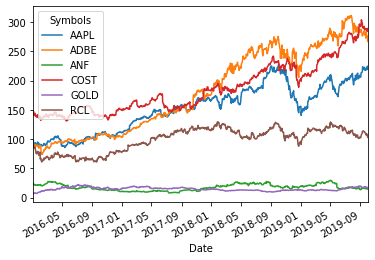

In [4]:
# Loading Test Data
# Setting Start and Enddate for Validation


start_test = datetime.datetime(2016, 1, 1)
end_test = datetime.datetime.now()

# Load Test Data

# Load several stocks
df_test = web.DataReader(['ADBE', 'AAPL', 'RCL', 'COST', 'ANF', 'GOLD'],'yahoo',
                               start=start_test, 
                               end=end_test)['Adj Close']

#Add random column for testing
#df_test['random']=np.random.randint(1,100,df_test.shape[0])
#df_test['sine']=50+50*np.sin(np.linspace(1,100,df_test.shape[0]))

# define second data input
df2_test = web.DataReader('GOLD','yahoo',
                               start=start_test, end=end_test)

# Convert df2_test to list
df2_test_list = list(df2_test['Adj Close'])


plt.figure();
df_test.plot();


In [ ]:
# Loop over all Models and test them
# If window size does not fit, pass and try next model



for models in os.listdir("models/"):

    
    #model_name = 'model_w15v2_40'
    model_name = models
    
    # Init Model
    window_size = 10

    try: 
        # Initialize Agent
        if df2_test_list is not None:
            agent = Agent(window_size*2, pretrained=True, model_name=model_name)
        else:
            agent = Agent(window_size, pretrained=True, model_name=model_name)

        sum = 0
        # Loop over stocks
        for column in df_test:
            #print(column)
            #rename feature column name
            df_test_list = list(df_test[column])
            dft = df_test.rename(columns={column: 'actual'})
            initial_offset = df_test_list[1] - df_test_list[0]
            val_result, history = evaluate_model(agent, df_test_list, df2_test_list, window_size, debug)
            show_eval_result(model_name, val_result, initial_offset);
            chart = visualize(dft, history)
            sum = sum+val_result
            #print("Earnings of Model: ", model_name, " is: ", val_result)
            #chart.display()
        print("Sum of all earnings: ", model_name, " is: ", sum)
    except: 
        print(models, "wrong windowsize")
        pass

model_GOOGL_10 wrong windowsize
model_GOOGL_20 wrong windowsize
model_GOOGL_30 wrong windowsize


Earnings of :  AAPL  is:  108.35307312011719


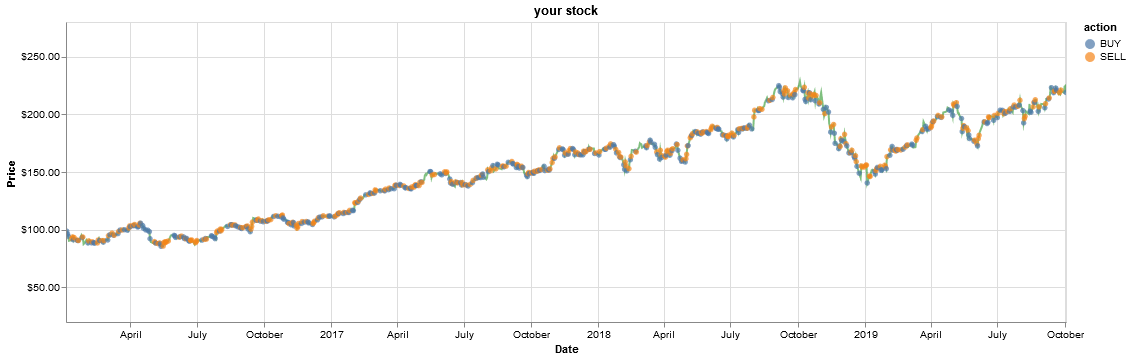

Earnings of :  ADBE  is:  435.42969512939453


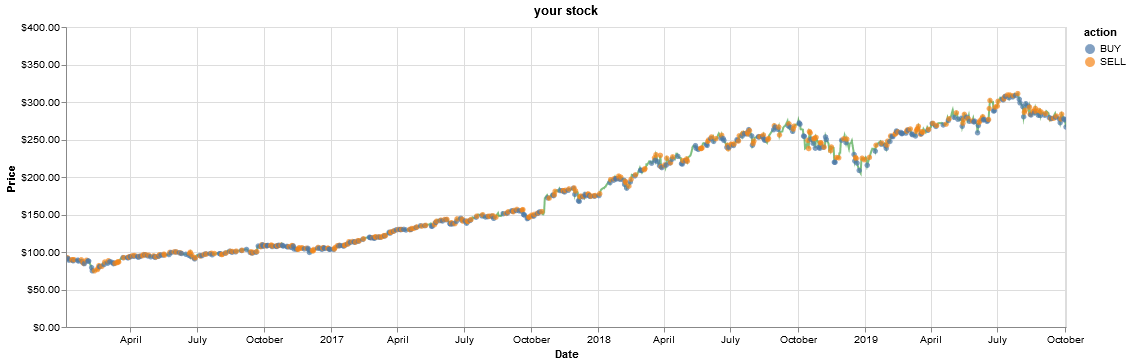

Earnings of :  ANF  is:  341.7534303665161


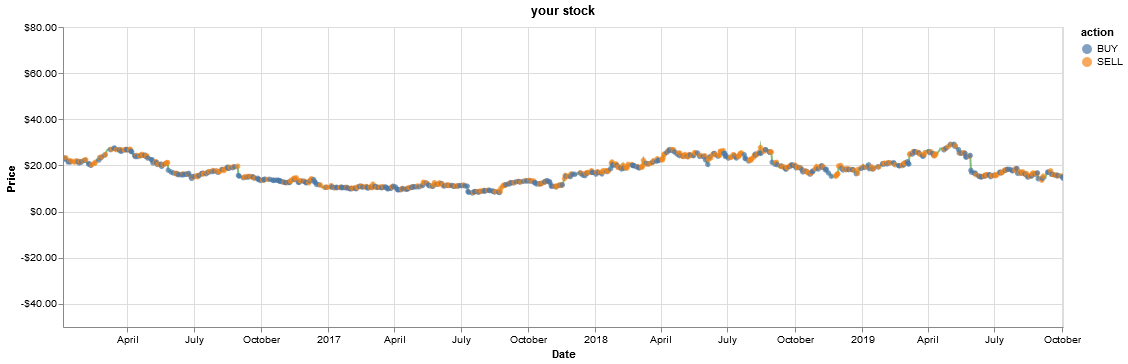

Earnings of :  COST  is:  134.74118041992188


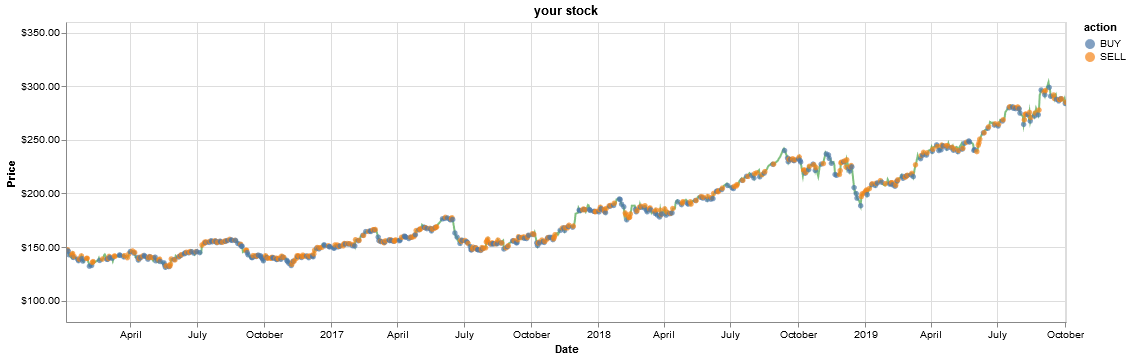

Earnings of :  GOLD  is:  144.29910850524902


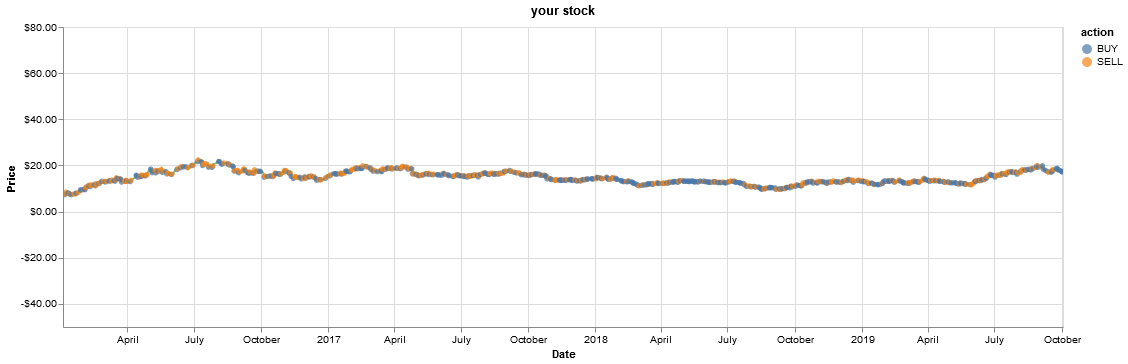

Earnings of :  RCL  is:  111.10065841674805


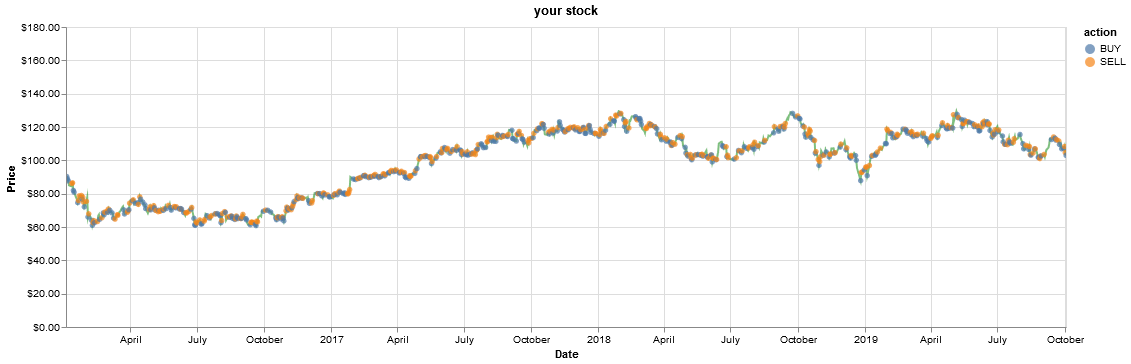

Sum of all earnings:  model_w15v2_30  is:  1275.6771459579468


In [9]:
# Test 1 model
    
#model_name = 'model_w15v2_40' model_Stefan_10
model_name = "model_w15v2_30"

# Init Model
window_size = 15


# Initialize Agent
if df2_test_list is not None:
    agent = Agent(window_size*2, pretrained=True, model_name=model_name)
else:
    agent = Agent(window_size, pretrained=True, model_name=model_name)

sum = 0
# Loop over stocks
for column in df_test:
    #print(column)
    #rename feature column name
    df_test_list = list(df_test[column])
    dft = df_test.rename(columns={column: 'actual'})
    initial_offset = df_test_list[1] - df_test_list[0]
    val_result, history = evaluate_model(agent, df_test_list, df2_test_list, window_size, debug)
    show_eval_result(model_name, val_result, initial_offset);
    chart = visualize(dft, history)
    sum = sum+val_result
    print("Earnings of : ", column, " is: ", val_result)
    chart.display()
print("Sum of all earnings: ", model_name, " is: ", sum)


In [10]:
dft.head(200)

Symbols,AAPL,ADBE,ANF,COST,GOLD,actual,position,action
Date,,,,,,,,
2016-01-04,98.742249,91.970001,23.073023,147.152557,7.478310,90.324860,90.324860,HOLD
2016-01-05,96.267815,92.339996,23.216385,147.512253,7.381814,88.852280,90.324860,BUY
2016-01-06,94.383888,91.019997,22.752563,146.147202,7.661649,87.720222,88.852280,BUY
2016-01-07,90.400467,89.110001,23.283852,142.799042,8.443253,85.069565,87.720222,BUY
2016-01-08,90.878479,87.849998,21.529758,140.299454,8.124820,84.471329,85.069565,HOLD
2016-01-11,92.350006,89.379997,21.816490,142.706802,7.864287,86.146400,84.471329,HOLD
2016-01-12,93.690300,89.820000,21.959852,143.942764,7.623052,86.532928,86.146400,SELL
2016-01-13,91.281494,88.300003,21.529758,140.308655,7.758143,81.949516,86.532928,SELL
2016-01-14,93.277916,89.800003,21.993586,141.286377,7.314269,80.900299,81.949516,BUY
